In [5]:
#need to automate go analysis with david
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_venn as mplv
import os
from math import *
from subprocess import *
import pybedtools as pbt
from glob import glob
import seaborn as sns
import statsmodels.formula.api as sm
import csv
import re
import scipy.stats as ss
csv.register_dialect("textdialect",delimiter='\t')
%matplotlib inline
mpl.rc("lines", markeredgewidth=0.5)


In [6]:
#What are the specific things I want to do GO on?
#Just do biological process to keep it simple
#differentially expressed genes during EMT (Twist) and hnRNPM knockdown
#differentiall expressed splicing during EMT (Twist) and hnRNPM knockdown

In [7]:
#PARSE rMATS SE Code
#May want to check with Anna about my genomic intervals operations
def parse_rMATS_SE(filename,read_cutoff):
    '''This function will parse rMATS output in filename to output only events that meet an
    FDR cutoff and PSI cutoff. The output include both positive and negative delta PSI as well
    as each separated
    Input: filename, FDR_cutoff which is a float 0-1, and PSI cutoff which is a float > 1, and read_cutoff which is and int'''
    rMATS_file = open(filename).readlines()
    rMATS_list = []
    for line in rMATS_file:
        line = line.strip().split('\t')
        fixed_line = []
        for x in line:
            x = x.strip('"')
            fixed_line.append(x)
        rMATS_list.append(fixed_line)
    #add a new column to the list withe the splice ID
    #Note - I would like to figure out how to do this with an existing dataframe
    for item in rMATS_list[0:1]:
        item.insert(0,"splice_id")
    for item in rMATS_list[1:]:
        splice_id = str(item[3]+':'+item[7]+'-'+item[8]+':'+item[5]+'-'+item[6]+':'+item[9]+'-'+item[10]+':'+item[4]+":"+item[2])
        item.insert(0,splice_id)
    #add new columns for sample_1_read_number and sample_2_read_number
    for item in rMATS_list[0:1]:
        item.insert(15,"SAMPLE_1_AVERAGE_READ")
    for item in rMATS_list[1:]:
        sample_1_ic_list = item[13].strip().split(',')
        sample_1_ic_numbers = [int(x) for x in sample_1_ic_list]
        sample_1_sc_list = item[14].strip().split(',')
        sample_1_sc_numbers = [int(x) for x in sample_1_sc_list]
        sample_1_average_read = np.mean(sample_1_ic_numbers) + np.mean(sample_1_sc_numbers)
        item.insert(15,sample_1_average_read)
    for item in rMATS_list[0:1]:
        item.insert(18,"SAMPLE_2_AVERAGE_READ")
    for item in rMATS_list[1:]:
        sample_2_ic_list = item[16].strip().split(',')
        sample_2_ic_numbers = [int(x) for x in sample_2_ic_list]
        sample_2_sc_list = item[17].strip().split(',')
        sample_2_sc_numbers = [int(x) for x in sample_2_sc_list]
        sample_2_average_read = np.mean(sample_2_ic_numbers) + np.mean(sample_2_sc_numbers)
        item.insert(18,sample_2_average_read)    
    #add new column for enhance or silence effect
    for item in rMATS_list[0:1]:
        item.append("splicing_factor_effect")
    for item in rMATS_list[1:]:
        if float(item[-1]) < 0:
            item.append("silence")
        else:
            item.append("enhance")
    #add new columns to have the mean of the PSI values since it is a comma separate list
    for item in rMATS_list[0:1]:
        item.insert(24,"inc_level_1_mean")
    for item in rMATS_list[1:]:
        mean = item[23].strip().split(',')
        mean_no_na = filter(lambda x: x != "NA",mean)
        mean_numbers = [float(i) for i in mean_no_na]
        mean_value = np.mean(mean_numbers)
        item.insert(24,mean_value)
    for item in rMATS_list[0:1]:
        item.insert(26,"inc_level_2_mean")
    for item in rMATS_list[1:]:
        mean = item[25].strip().split(',')
        mean_no_na = filter(lambda x: x != "NA",mean)
        mean_numbers = [float(i) for i in mean_no_na]
        mean_value = np.mean(mean_numbers)
        item.insert(26,mean_value)
    #Remove scaffold chromosomes:
    c_list = ['chrX','chr13','chr12','chr11','chr10','chr17','chr16','chr15','chr14','chr19','chr18','chr22','chr20','chr21','chr7','chr6','chr5','chr4','chr3','chr2','chr1','chr9','chr8']
    for item in rMATS_list[1:]:
        if item[4] not in c_list:
            rMATS_list.remove(item)
    #write this file as a csv for easier import into pandas. Then import it
    with open('tempfile','wb') as temp:
        tempwriter = csv.writer(temp,delimiter='\t')
        for item in rMATS_list:
            tempwriter.writerow(item)
    with open('tempfile') as temp:
        rMATS_df = pd.read_csv(temp,sep='\t')
    os.remove('tempfile')
    #Fix Gene ID so it is just the ens_ID
    rMATS_df['ens_gene'] = rMATS_df.GeneID.str.split('.').str[0]
    #Append ens_gene to splice ID
    rMATS_df['splice_id'] = rMATS_df['splice_id'].astype('str') + ':' + rMATS_df['ens_gene'].astype('str')
    #remove samples less than read cutoff. This means that each sample must have inc + exc >= read cutoff
    rMATS_df = rMATS_df[rMATS_df.SAMPLE_1_AVERAGE_READ >= read_cutoff]
    rMATS_df = rMATS_df[rMATS_df.SAMPLE_2_AVERAGE_READ >= read_cutoff]
    
#     #remove FDR > FDR_cutoff
#     rMATS_df = rMATS_df[rMATS_df.FDR < FDR_cutoff]
#     #remove those beneath delta PSI cutoff
#     rMATS_df = rMATS_df[rMATS_df.IncLevelDifference.abs() >= PSI_cutoff]
    return rMATS_df

In [8]:
%%time
#load in the skipped exon files as variable for the rMATS analysis: Just do the new rMATS first
twist = '/media/sam/Data1/bcm_star_alignments/SEH_bcm/rMATS_3_2_5_results/SEH-1_SEH-2_with_gencode_25lift37/MATS_output/SEH-1_SEH-2_rMATS_3_2_5_SE_ROT'
cc1_cc2 = '/media/sam/Data1/bcm_star_alignments/CC_bcm/rMATS_3_2_5_results/CC-1_CC-2/MATS_output/CC-1_CC-2_rMATS_3_2_5_SE_ROT'
cc3_cc4 = '/media/sam/Data1/bcm_star_alignments/CC_bcm/rMATS_3_2_5_results/CC-3_CC-4/MATS_output/CC-3_CC-4_rMATS_3_2_5_SE_ROT'
hh5_hh6 = '/media/sam/Data1/bcm_star_alignments/HH_bcm/rMATS_3_2_5_results/HH-5_HH-6/MATS_output/HH-5_HH-6_rMATS_3_2_5_SE_ROT'

#also bring in the other EMT sets... tgf-b, snail

#Run parse_rMATS_SE on each
# FDR = 0.05
# PSI = 0.1
reads = 20
twist_rMATS_df = parse_rMATS_SE(filename=twist,read_cutoff=reads)
cc1_cc2_rMATS_df = parse_rMATS_SE(filename=cc1_cc2,read_cutoff=reads)
cc3_cc4_rMATS_df = parse_rMATS_SE(filename=cc3_cc4,read_cutoff=reads)
hh5_hh6_rMATS_df = parse_rMATS_SE(filename=hh5_hh6,read_cutoff=reads)

CPU times: user 23.2 s, sys: 512 ms, total: 23.7 s
Wall time: 23.2 s


In [9]:
%%time
#Write a function dealing with the intersection dataframes to filter by FDR and delta PSI
def filter_fdr_and_psi(intersect_df,FDR,dPSI):
    intersect_df_filtered = intersect_df[intersect_df.FDR <= FDR]
    intersect_df_filtered = intersect_df_filtered[intersect_df_filtered.IncLevelDifference.abs() >= dPSI]
    return intersect_df_filtered

#Process each dataframe with full rMATS dataframe and exon_intersect_df with this function
FDR = 0.05
dPSI = 0.1

twist_rMATS_df_filtered = filter_fdr_and_psi(twist_rMATS_df,FDR,dPSI)
cc1_cc2_rMATS_df_filtered = filter_fdr_and_psi(cc1_cc2_rMATS_df,FDR,dPSI)
cc3_cc4_rMATS_df_filtered = filter_fdr_and_psi(cc3_cc4_rMATS_df,FDR,dPSI)
hh5_hh6_rMATS_df_filtered = filter_fdr_and_psi(hh5_hh6_rMATS_df,FDR,dPSI)

#cc1_cc4_rMATS_df_filtered = filter_fdr_and_psi(cc1_cc4_rMATS_df,FDR,dPSI)

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 18.1 ms


In [12]:
# #need to set index as splice ID
# cc1_cc2_rMATS_df_reindex = cc1_cc2_rMATS_df.set_index('splice_id',drop=False)
# cc3_cc4_rMATS_df_reindex = cc3_cc4_rMATS_df.set_index('splice_id',drop=False)

# #need to combine cc1_and_cc4 including combinding the PSI values. Just take the mean of everything
# cc1_cc4_rMATS_df = pd.concat((cc1_cc2_rMATS_df_reindex,cc3_cc4_rMATS_df_reindex),)

# #I DON'T KNOW HOW TO DO THIS. I tried to do it via bedtools groupby but no luck
# #I just combined everything and averaged



In [13]:
# cc1_cc4_rMATS_df = pd.concat([cc1_cc2_rMATS_df,cc3_cc4_rMATS_df],ignore_index=True)
# #now write to file and stuff
# # cc1_cc4_rMATS_columns_list = cc1_cc4_rMATS_df.columns.tolist()
# # cc1_cc4_rMATS_df.to_csv('cc1_cc4_rMATS_df',sep='\t',index=False,header=True)
# # !bedtools groupby -g 1,3,4,5,6,7,8,9,10,11,12,30 -c 2,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29 -o mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,distinct,distinct -inheader > cc1_cc4_rMATS_df_grouped

In [15]:
#This is the means of combining CC1-CC2 and CC3-CC4 I ultimately used to retain PSI value for plotting. Not the best way...

#What if we take the filtered set for cc1 and cc2, and then cc3 and cc4. then combine the mean inc level difference and just replace cc1 and cc2's set
cc1_cc2_splice_id_set = set(cc1_cc2_rMATS_df_filtered.splice_id.tolist())
cc3_cc4_splice_id_set = set(cc3_cc4_rMATS_df_filtered.splice_id.tolist())
combined_set = cc1_cc2_splice_id_set.intersection(cc3_cc4_splice_id_set)
combined_list = list(combined_set)

cc1_cc2_unique_list = list(cc1_cc2_splice_id_set.difference(cc3_cc4_splice_id_set))
cc3_cc4_unique_list = list(cc3_cc4_splice_id_set.difference(cc1_cc2_splice_id_set))

cc1_cc2_shared_df = cc1_cc2_rMATS_df_filtered.loc[cc1_cc2_rMATS_df_filtered.splice_id.isin(combined_list)]
cc1_cc2_shared_df.sort_values('splice_id',inplace=True)
cc1_cc2_shared_df.to_csv('cc1_cc2_same.txt',sep='\t',index=False)
cc3_cc4_shared_df = cc3_cc4_rMATS_df_filtered.loc[cc3_cc4_rMATS_df_filtered.splice_id.isin(combined_list)]
cc3_cc4_shared_df.sort_values('splice_id',inplace=True)
cc3_cc4_shared_df.to_csv('cc3_cc4_same.txt',sep='\t',index=False)

cc1_cc2_unique_df = cc1_cc2_rMATS_df_filtered.loc[cc1_cc2_rMATS_df_filtered.splice_id.isin(cc1_cc2_unique_list)]
cc3_cc4_unique_df = cc3_cc4_rMATS_df_filtered.loc[cc3_cc4_rMATS_df_filtered.splice_id.isin(cc3_cc4_unique_list)]
#Note I just fixed this in excel by taking the average PSI value between cc1,cc2,cc3,and cc4. Not the best way
cc1_cc2_combined_df = pd.read_table('/home/sam/Dropbox/cheng_workstation/fixed_cc1_cc2.txt')

cc1_cc4_rMATS_df = pd.concat([cc1_cc2_unique_df,cc3_cc4_unique_df,cc1_cc2_combined_df],ignore_index=True)

#actually filter this by FDR and dPSI
FDR = 0.05
dPSI = 0.1
cc1_cc4_rMATS_df_filtered = filter_fdr_and_psi(cc1_cc4_rMATS_df,FDR,dPSI)

cc1_cc4_rMATS_df_filtered.to_csv('cc1_cc4_rMATS_df_filtered',index=False)
# cc1_cc4_rMATS_df_filtered.describe()

,ID,exonStart_0base,exonEnd,upstreamES,upstreamEE,downstreamES,downstreamEE,ID.1,IC_SAMPLE_1,SC_SAMPLE_1,...,SAMPLE_2_AVERAGE_READ,IncFormLen,SkipFormLen,PValue,FDR,IncLevel1,inc_level_1_mean,IncLevel2,inc_level_2_mean,IncLevelDifference
count,1891.000000,1.891000e+03,1.891000e+03,1.891000e+03,1.891000e+03,1.891000e+03,1.891000e+03,1891.000000,1891.000000,1891.000000,...,1891.000000,1891.000000,1891.0,1.891000e+03,1891.000000,1891.000000,1891.000000,1891.000000,1891.000000,1891.000000
mean,35905.674246,7.745836e+07,7.745852e+07,7.744978e+07,7.745001e+07,7.746695e+07,7.746717e+07,35905.674246,295.651507,98.795346,...,296.630354,255.524061,99.0,3.893719e-04,0.011488,0.573488,0.573488,0.641072,0.641072,-0.057337
std,20711.953418,5.596952e+07,5.596952e+07,5.596859e+07,5.596857e+07,5.597007e+07,5.597007e+07,20711.953418,607.100253,292.792810,...,568.174693,215.957498,0.0,5.610622e-04,0.014508,0.317020,0.317020,0.295396,0.295396,0.234901
min,8.000000,8.788000e+04,8.801700e+04,8.755600e+04,8.770300e+04,8.856900e+04,8.877100e+04,8.000000,0.000000,0.000000,...,20.000000,105.000000,99.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,-0.734000
25%,17511.000000,3.470467e+07,3.470479e+07,3.467372e+07,3.467383e+07,3.470565e+07,3.470580e+07,17511.000000,52.000000,13.000000,...,72.000000,178.000000,99.0,4.053106e-07,0.000040,0.283500,0.283500,0.392500,0.392500,-0.207750
50%,36995.000000,6.605370e+07,6.605378e+07,6.604848e+07,6.604881e+07,6.608435e+07,6.608446e+07,36995.000000,136.000000,41.000000,...,155.000000,216.000000,99.0,7.560621e-05,0.003837,0.647000,0.647000,0.714000,0.714000,-0.131000
75%,54086.000000,1.115727e+08,1.115735e+08,1.115704e+08,1.115705e+08,1.115868e+08,1.115871e+08,54086.000000,329.000000,101.000000,...,327.000000,261.500000,99.0,6.156483e-04,0.020155,0.853500,0.853500,0.900000,0.900000,0.138000
max,74083.000000,2.451805e+08,2.451806e+08,2.451337e+08,2.451337e+08,2.452227e+08,2.452228e+08,74083.000000,14082.000000,8289.000000,...,11658.000000,3984.000000,99.0,2.164920e-03,0.049996,1.000000,1.000000,1.000000,1.000000,0.706000


In [49]:
#Obtain all of the spliced genes regardless of filtering. These are all of the genes with evidence of splicing regardless if they did not change significanlty 
twist_rMATS_df.ens_gene.to_csv('grace_go_analysis/twist_all_spliced_genes',index=False,header=False)
hh5_hh6_rMATS_df.ens_gene.to_csv('grace_go_analysis/hh5_hh6_all_spliced_genes',index=False,header=False)
cc1_cc4_rMATS_df.ens_gene.to_csv('grace_go_analysis/cc1_cc4_all_spliced_genes',index=False,header=False)

In [35]:
#also collect all of the differentially expressed genes from the EMT analysis - this is where I can access the twist-ER cuffdiff data
path = '../../emt_rna_binding_proteins/emt_merge_df'
emt_merge_df = pd.read_csv(path,sep='\t')

#pull out twist only
cols = ['gene_id','gene','locus','twist_epi_FPKM','twist_mes_FPKM','twist_log2_fold_change','twist_q_value','biotype']
twist_cuff_df = emt_merge_df[cols]
#renname the gene_id colum to 'ens_gene'
twist_cuff_df.rename(columns={'gene_id':'ens_gene','gene':'external_gene_name','twist_epi_FPKM':'value_1','twist_mes_FPKM':'value_2','twist_q_value':'q_value','twist_log2_fold_change':'log2(fold_change)'},inplace=True)

#collect cc and hh cuffdiff
cc1_cc2_cuff_df = pd.read_csv('master_go_analysis/cc1_cc2_cuffdiff_with_biotype.txt',sep='\t')
cc3_cc4_cuff_df = pd.read_csv('master_go_analysis/cc3_cc4_cuffdiff_with_biotype.txt',sep='\t')
hh5_hh6_cuff_df = pd.read_csv('master_go_analysis/hh5_hh6_cuffdiff_with_biotype.txt',sep='\t')

#rename all log2(fold_change) to a proper thing
def rename_log2_fold_change(dataframe):
    renamed = dataframe.rename(columns={'log2(fold_change)':'log2_fold_change','gene_id':'ens_gene','gene':'external_gene_name'})
    return renamed

twist_cuff_df = rename_log2_fold_change(twist_cuff_df)
cc1_cc2_cuff_df = rename_log2_fold_change(cc1_cc2_cuff_df)
cc3_cc4_cuff_df = rename_log2_fold_change(cc3_cc4_cuff_df)
hh5_hh6_cuff_df = rename_log2_fold_change(hh5_hh6_cuff_df)

#THIS IS WHERE i JUST CONTENATE. AS LONG AS I USED SETS IT DOESN'T MATTER. THERE WILL BE MANY DUPLICATES THAT WILL BE COLLAPSED ON SETS, INCLUDING RMATS
#concatenate cc1_cc2 and cc3_cc4 for cuff and rMATS. You will ultimately get the union
#cc1_cc4_rMATS_df = pd.concat([cc1_cc2_rMATS_df,cc3_cc4_rMATS_df],ignore_index=True)
cc1_cc4_cuff_df = pd.concat([cc1_cc2_cuff_df,cc3_cc4_cuff_df],ignore_index=True)

In [47]:
#write the gene list that is over the fpkm cutoff for value 1 to a list or value 2. We want to exceed an arbitrary designation

#For some reason the background list doesn't do anything
def save_background_list(dataframe,fpkm_cutoff,sample_name):
    fpkm_cut_df = dataframe[(dataframe.value_1 > fpkm_cutoff) | (dataframe.value_2 > fpkm_cutoff) ]
    fpkm_cut_df.ens_gene.to_csv('master_go_analysis/'+sample_name+'_background_genes_fpkm_'+str(fpkm_cutoff),sep='\t',index=False)
#     return fpkm_cut_df
    
#     with open('master_go_analysis/'+sample_name+'_gene_background_fpkm_'+str(fpkm_cutoff),'w') as f:
fpkm_cutoff = 1

save_background_list(twist_cuff_df,fpkm_cutoff,'twist')
save_background_list(cc1_cc2_cuff_df,fpkm_cutoff,'cc1_cc2')
save_background_list(cc3_cc4_cuff_df,fpkm_cutoff,'cc3_cc4')
save_background_list(hh5_hh6_cuff_df,fpkm_cutoff,'hh5_hh6')

save_background_list(cc1_cc4_cuff_df,fpkm_cutoff,'cc1_cc4')

        

In [48]:
#write a function to only select log2(fold change) > 1
#set fpkm cutoff so expression is at least 5 in one sample
def filter_cuffdiff(dataframe,fold_change,fpkm_cutoff):
    filtered_df = dataframe[dataframe.log2_fold_change.abs() >= fold_change]
    filtered_df = filtered_df[(filtered_df.value_1 >= fpkm_cutoff) | (filtered_df.value_2 >= fpkm_cutoff)]
    return filtered_df

fold_change = 1
fpkm_cutoff = 5

twist_cuff_df_filtered = filter_cuffdiff(twist_cuff_df,fold_change,fpkm_cutoff)
cc1_cc2_cuff_df_filtered = filter_cuffdiff(cc1_cc2_cuff_df,fold_change,fpkm_cutoff)
cc3_cc4_cuff_df_filtered = filter_cuffdiff(cc3_cc4_cuff_df,fold_change,fpkm_cutoff)
hh5_hh6_cuff_df_filtered = filter_cuffdiff(hh5_hh6_cuff_df,fold_change,fpkm_cutoff)


cc1_cc4_cuff_df_filtered = filter_cuffdiff(cc1_cc4_cuff_df,fold_change,fpkm_cutoff)

In [38]:
from itertools import izip_longest
#write a function to compare and generate the venn diagram for comparing splicing and comparing gene expression
#also return the 3 groups
def compare_genes_diff_and_spliced(cuff_df,mats_df,sample_name):
    plt.figure(figsize=(5,5))
    plt.title(sample_name,fontsize=30)
    cuff_set = set(cuff_df.ens_gene.tolist())
    cuff_list = list(cuff_set)
    cuff_list.insert(0,sample_name+'_all_diff_genes')
    mats_set = set(mats_df.ens_gene.tolist())
    mats_list = list(mats_set)
    mats_list.insert(0,sample_name+'_all_diff_spliced')
    intersection = list(cuff_set.intersection(mats_set))
    intersection.insert(0,sample_name+'_intersection')
    gene_diff_only = list(cuff_set.difference(mats_set))
    gene_diff_only.insert(0,sample_name+'_gene_diff_only')
    splice_diff_only = list(mats_set.difference(cuff_set))
    splice_diff_only.insert(0,sample_name+'_splice_diff_only')
    mplv.venn2([set(cuff_df.ens_gene.tolist()),set(mats_df.ens_gene.tolist())],set_labels=(sample_name+'\ndiff exp genes',sample_name+'\ndiff spliced genes'))
    
    #combine the list
    megalist = [cuff_list,mats_list,intersection,gene_diff_only,splice_diff_only]
    
    #now write to file
    with open('master_go_analysis/'+sample_name+'_gene_diff_vs_splice_diff.txt','w') as f:
        writer = csv.writer(f,'textdialect')
        writer.writerows(izip_longest(*megalist,fillvalue=""))
#         for item in mega_list:
#             f.write(item[0]+'\t'+item[1]+'\t'+item[2]+'\t'+item[3]+'\t'+item[4]+'\n')
#     with open('master_go_analysis/'+sample_name+'gene_and_splice_intersection','w') as f:
#         for item in intersection:
#             f.write(item+'\n')
#     with open('master_go_analysis/'+sample_name+'gene_only','w') as f:
#         for item in gene_diff_only:
#             f.write(item+'\n')
#     with open('master_go_analysis/'+sample_name+'splice_only','w') as f:
#         for item in splice_diff_only:
#             f.write(item+'\n')
    return (intersection,gene_diff_only,splice_diff_only)

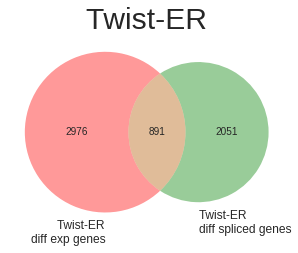

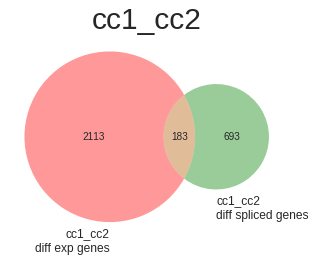

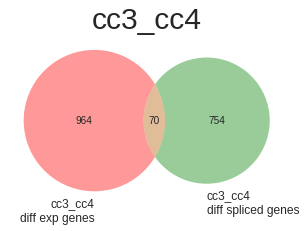

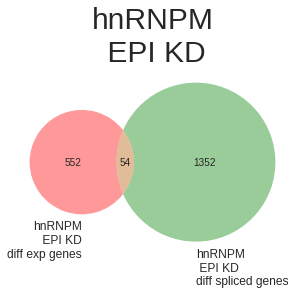

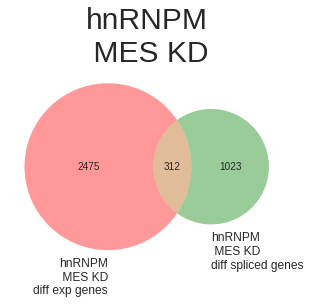

In [39]:
#This shows how many genes were splice and how many were differentially expressed between the samples
(twist_inter,twist_gene_diff_only,twist_splice_diff_only) = compare_genes_diff_and_spliced(twist_cuff_df_filtered,twist_rMATS_df_filtered,'Twist-ER')
(cc1_cc2_inter,cc1_cc2_gene_diff_only,cc1_cc2_splice_diff_only) = compare_genes_diff_and_spliced(cc1_cc2_cuff_df_filtered,cc1_cc2_rMATS_df_filtered,'cc1_cc2')
(cc3_cc4_inter,cc3_cc4_gene_diff_only,cc3_cc4_splice_diff_only) = compare_genes_diff_and_spliced(cc3_cc4_cuff_df_filtered,cc3_cc4_rMATS_df_filtered,'cc3_cc4')
(hh5_hh6_inter,hh5_hh6_gene_diff_only,hh5_hh6_splice_diff_only) = compare_genes_diff_and_spliced(hh5_hh6_cuff_df_filtered,hh5_hh6_rMATS_df_filtered,'hnRNPM\n EPI KD')

(cc1_cc4_inter,cc1_cc4_gene_diff_only,cc1_cc4_splice_diff_only) = compare_genes_diff_and_spliced(cc1_cc4_cuff_df_filtered,cc1_cc4_rMATS_df_filtered,'hnRNPM\n MES KD')

<matplotlib_venn._common.VennDiagram instance at 0x7f965c84a950>

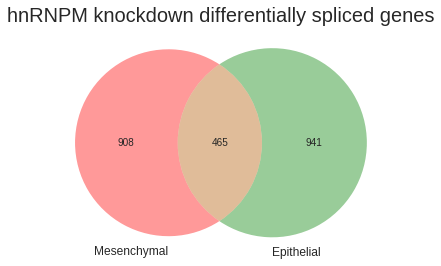

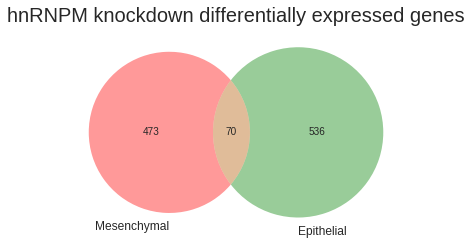

In [54]:
#THIS USES THE COMBINED CC TO MAKE A MASTER MESENCHYMAL SET VS THE EPITHELIAL SET

#combine the set of spliced from hnRNPM cc1_cc2
cc1_cc2_set = set(cc1_cc2_rMATS_df_filtered.ens_gene.tolist())
cc3_cc4_set = set(cc3_cc4_rMATS_df_filtered.ens_gene.tolist())

#combine - this is larger than it should be because we are not filtering out the overlap. We are just taking everything that was significant in either
cc1_cc4_set = cc1_cc2_set.union(cc3_cc4_set)

hh5_hh6_set = set(hh5_hh6_rMATS_df_filtered.ens_gene.tolist())

#splicing venn diagram
fig = plt.figure(figsize=(6,6))
plt.title('hnRNPM knockdown differentially spliced genes',fontsize=20)
mplv.venn2([cc1_cc4_set,hh5_hh6_set],set_labels=('Mesenchymal','Epithelial'))

#combine the set of genes
cc1_cc2_gene_set = set(cc1_cc2_cuff_df_filtered.ens_gene.tolist())
cc3_cc4_gene_set = set(cc3_cc4_cuff_df_filtered.ens_gene.tolist())
#combine - BUT HERE YOU CAN TAKE THE INTERSECTION OR THE UNION
cc1_cc4_gene_set = cc1_cc2_gene_set.intersection(cc3_cc4_gene_set)

hh5_hh6_gene_set = set(hh5_hh6_cuff_df_filtered.ens_gene.tolist())

#gene venn diagram
fig = plt.figure(figsize=(6,6))
plt.title('hnRNPM knockdown differentially expressed genes',fontsize=20)
mplv.venn2([cc1_cc4_gene_set,hh5_hh6_gene_set],set_labels=('Mesenchymal','Epithelial'))


In [41]:
#This compares differentially spliced genes between two samples even though it is names cuff_df and mats_df

def compare_spliced_and_spliced(cuff_df,mats_df,sample_name_1,sample_name_2):
    plt.figure(figsize=(5,5))
#     plt.title('Differentially spliced genes: '+sample_name_1+'_vs_'+sample_name_2,fontsize=20)
    cuff_set = set(cuff_df.ens_gene.tolist())
    cuff_list = list(cuff_set)
    cuff_list.insert(0,sample_name_1+'_all_spliced_genes')
    mats_set = set(mats_df.ens_gene.tolist())
    mats_list = list(mats_set)
    mats_list.insert(0,sample_name_2+'_all_spliced_genes')
    intersection = list(cuff_set.intersection(mats_set))
    intersection.insert(0,sample_name_1+'_'+sample_name_2+'_intersection')
    gene_diff_only = list(cuff_set.difference(mats_set))
    gene_diff_only.insert(0,sample_name_1+'_splice_only')
    splice_diff_only = list(mats_set.difference(cuff_set))
    splice_diff_only.insert(0,sample_name_2+'_splice_only')
    plt.figure(figsize=(8,8))
    mplv.venn2([set(cuff_df.ens_gene.tolist()),set(mats_df.ens_gene.tolist())],set_labels=(sample_name_1,sample_name_2),set_colors=('b','g'))
    plt.figure(figsize=(8,8))
    
    #combine the list
    megalist = [cuff_list,mats_list,intersection,gene_diff_only,splice_diff_only]
    
    #now write to file
    with open('master_go_analysis/'+sample_name_1+'_vs_'+sample_name_2+'_splicing.txt','w') as f:
        writer = csv.writer(f,'textdialect')
        writer.writerows(izip_longest(*megalist,fillvalue=""))

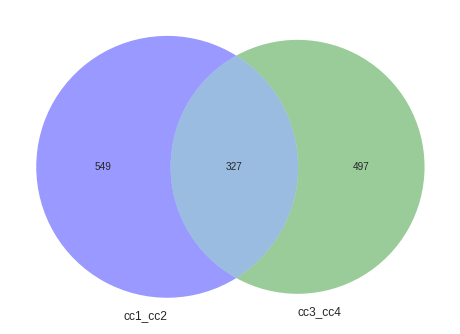

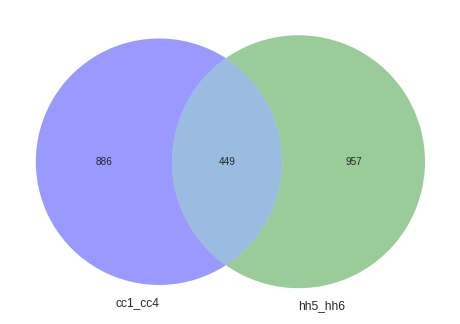

In [53]:
#How much overlap between CC1_CC2 and CC3_CC4
compare_spliced_and_spliced(cc1_cc2_rMATS_df_filtered,cc3_cc4_rMATS_df_filtered,'cc1_cc2','cc3_cc4')
compare_spliced_and_spliced(cc1_cc4_rMATS_df_filtered,hh5_hh6_rMATS_df_filtered,'cc1_cc4','hh5_hh6')

In [50]:
def compare_gene_and_gene(cuff_df,mats_df,sample_name_1,sample_name_2):
    plt.figure(figsize=(5,5))
    plt.title('Differentially expressed genes: '+sample_name_1+'_vs_'+sample_name_2,fontsize=20)
    cuff_set = set(cuff_df.ens_gene.tolist())
    cuff_list = list(cuff_set)
    cuff_list.insert(0,sample_name_1+'_all_diff_genes')
    mats_set = set(mats_df.ens_gene.tolist())
    mats_list = list(mats_set)
    mats_list.insert(0,sample_name_2+'_all_diff_genes')
    intersection = list(cuff_set.intersection(mats_set))
    intersection.insert(0,sample_name_1+'_'+sample_name_2+'_intersection')
    gene_diff_only = list(cuff_set.difference(mats_set))
    gene_diff_only.insert(0,sample_name_1+'_gene_diff_only')
    splice_diff_only = list(mats_set.difference(cuff_set))
    splice_diff_only.insert(0,sample_name_2+'_gene_diff_only')
    mplv.venn2([set(cuff_df.ens_gene.tolist()),set(mats_df.ens_gene.tolist())],set_labels=(sample_name_1+' diff exp genes',sample_name_2+' diff exp genes'))
    
    #combine the list
    megalist = [cuff_list,mats_list,intersection,gene_diff_only,splice_diff_only]
    
    #now write to file
    with open('master_go_analysis/'+sample_name_1+'_vs_'+sample_name_2+'_gene_exp.txt','w') as f:
        writer = csv.writer(f,'textdialect')
        writer.writerows(izip_longest(*megalist,fillvalue=""))

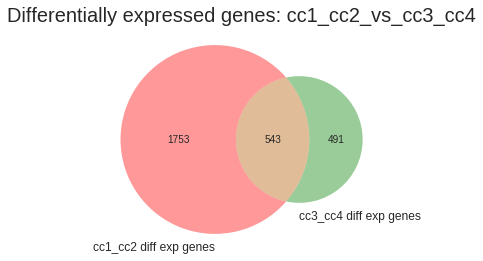

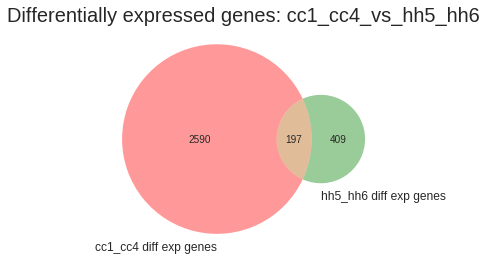

In [51]:
#why does cc1 and cc2 have so many more diff genes? Depth? Library? what?
#CC1 = 72054086
#CC2 = 52153290
#CC3 = 93051119
#CC4 = 63065008

compare_gene_and_gene(cc1_cc2_cuff_df_filtered,cc3_cc4_cuff_df_filtered,'cc1_cc2','cc3_cc4')
compare_gene_and_gene(cc1_cc4_cuff_df_filtered,hh5_hh6_cuff_df_filtered,'cc1_cc4','hh5_hh6')

In [27]:
#What if I just use the st of cc1_cc4_intersection genes... There are 543 of them.

In [57]:
#write a function to go into the david output and collect the data for the 3 bar graphs and then plot
#How am I going to do this. Pull everything out as a dataframe
def david_bar_graph(david_sample_1_file,david_sample_2_file,david_intersection_file,sample_1,sample_2,go_term_id,sig_cutoff):
    '''This actually just takes 3 david files and then outputs the bar graph for each of them'''
    sample_1_only = pd.read_csv(david_sample_1_file,sep='\t')
    sample_2_only = pd.read_csv(david_sample_2_file,sep='\t')
    intersection = pd.read_csv(david_intersection_file,sep='\t')

    #collect only the GOTERM_BP_DIRECT
    def collect_id_of_interest(id_of_interest,dataframe):
        dataframe = dataframe[dataframe.Category == id_of_interest]
        return dataframe

    sample_1_only = collect_id_of_interest(go_term_id,sample_1_only)
    sample_2_only = collect_id_of_interest(go_term_id,sample_2_only)
    intersection = collect_id_of_interest(go_term_id,intersection)

    #now need to filter by a neg_log_p value
    def neg_log_p_and_filter_go(cutoff,dataframe):
        dataframe['neglogP'] = dataframe.apply(lambda row: -1*log(row['PValue'],10),axis=1)
        dataframe = dataframe[dataframe.neglogP > cutoff]
        #set a top 10
        dataframe = dataframe.head(5)
        return dataframe

    sample_1_only = neg_log_p_and_filter_go(sig_cutoff,sample_1_only)
    sample_2_only = neg_log_p_and_filter_go(sig_cutoff,sample_2_only)
    intersection = neg_log_p_and_filter_go(sig_cutoff,intersection)
    
    sample_1_only['sample'] = sample_1
    sample_2_only['sample'] = sample_2
    intersection['sample'] = sample_1+'\nand '+sample_2
    
    combined = pd.concat([sample_1_only,sample_2_only,intersection],ignore_index=True)
    
    #how could I plot side by side?
    #try an sns barplot after concat
    sns.set(font_scale=2.5)
    plt.figure(figsize=(10,15))
    sns.barplot(x='neglogP',y='Term',hue='sample',data=combined,orient='h')
    plt.legend(bbox_to_anchor=(1.75,1))

    #now blot a bar graph for each one
#     fig,ax = plt.subplots(3,1,figsize=(10,20),sharey=False,sharex=True)
#     sample_1_only.plot.barh(x='Term',y='neglogP',fontsize=15,ax=ax[0],label=sample_1+'_only',color='r')
#     sample_2_only.plot.barh(x='Term',y='neglogP',fontsize=15,ax=ax[1],label=sample_2+'_only',color='g')
#     intersection.plot.barh(x='Term',y='neglogP',fontsize=15,ax=ax[2],label=sample_1+'_and_'+sample_2,color='y')
        
    #add tables
#     from pandas.tools.plotting import table
#     table(ax[0],sample_1_only[['Count','%']],loc='right')
    
    #Figure out how to set a label with how many genes there are in each go term
    
    
    


In [58]:
cc1_cc4_gene_df = pd.read_table('master_go_analysis/epi_vs_mes_hnM_knockdown_genes_diff_log_ratio_1/cc1_cc4_gene_diff_only.txt')
hh5_hh6_gene_df = pd.read_table('master_go_analysis/epi_vs_mes_hnM_knockdown_genes_diff_log_ratio_1/hh5_hh6_gene_diff_only.txt')

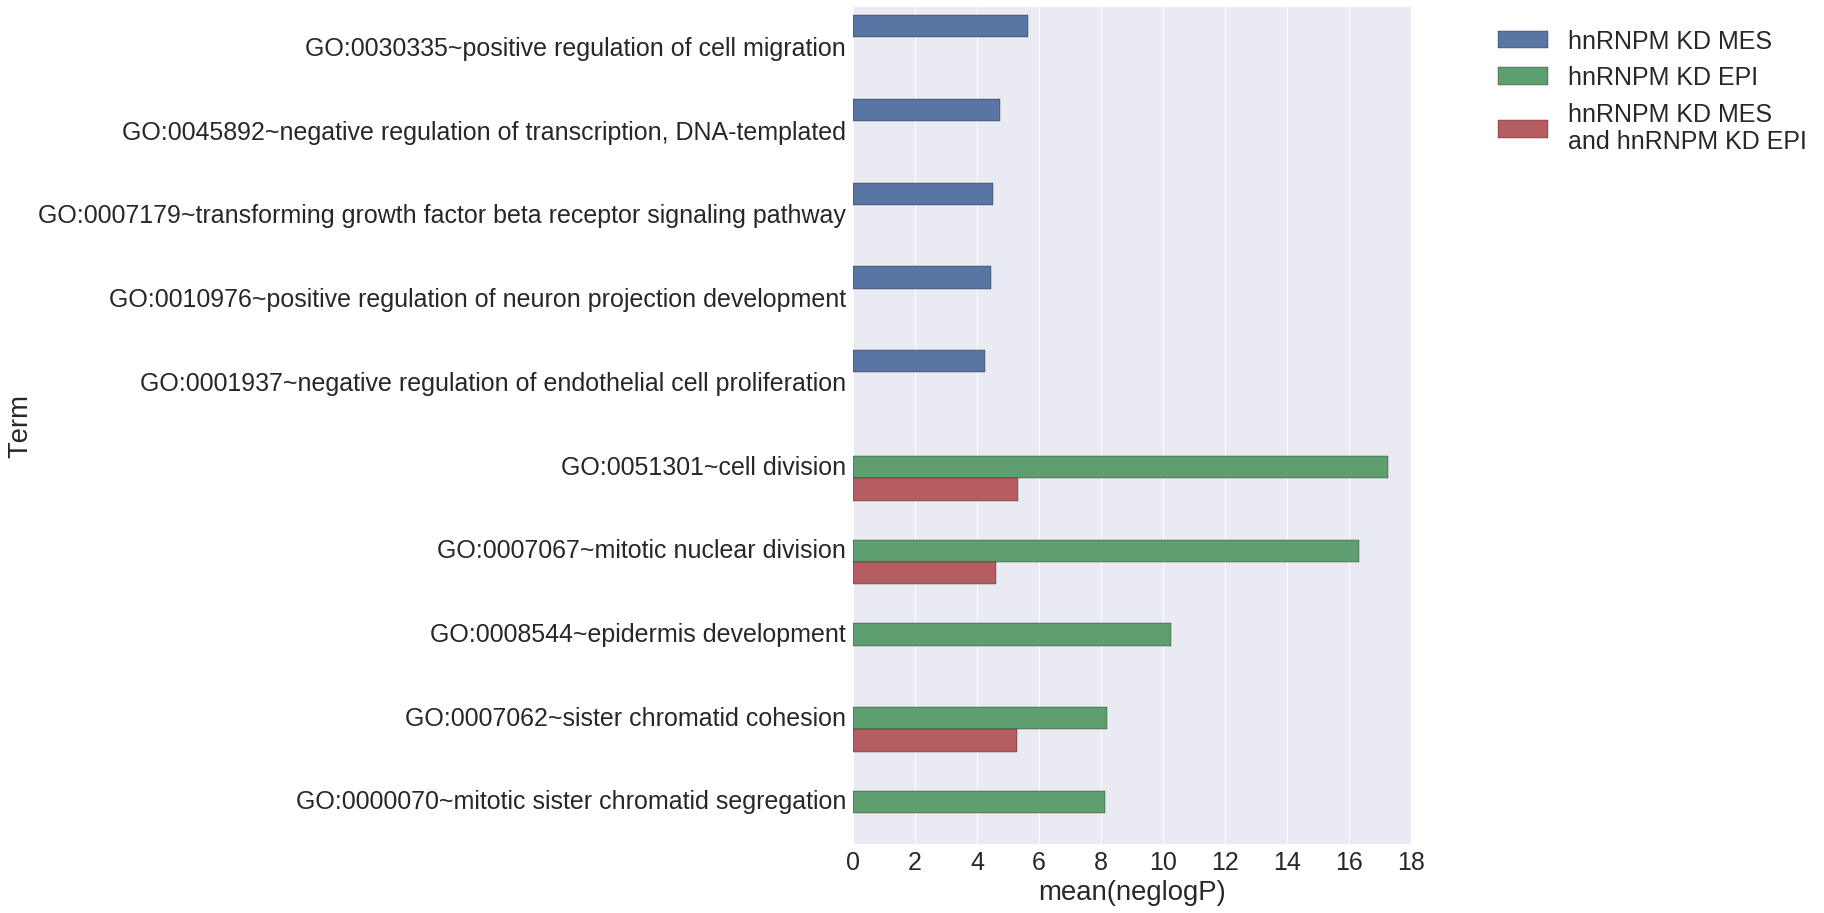

In [60]:
#EPI VS MES GENE EXPRESSION
cc1_cc4_gene = 'master_go_analysis/epi_vs_mes_hnM_knockdown_genes_diff_log_ratio_1/cc1_cc4_gene_diff_only.txt'
hh5_hh6_gene = 'master_go_analysis/epi_vs_mes_hnM_knockdown_genes_diff_log_ratio_1/hh5_hh6_gene_diff_only.txt'
both_gene = 'master_go_analysis/epi_vs_mes_hnM_knockdown_genes_diff_log_ratio_1/cc1_cc4_hh5_hh6_intersection_gene.txt'
# compare_gene_and_gene(cc1_cc4_cuff_df_filtered,hh5_hh6_cuff_df_filtered,'hnRNPM KD MES','hnRNPM KD EPI')
test = david_bar_graph(cc1_cc4_gene,hh5_hh6_gene,both_gene,'hnRNPM KD MES','hnRNPM KD EPI','GOTERM_BP_DIRECT',3)

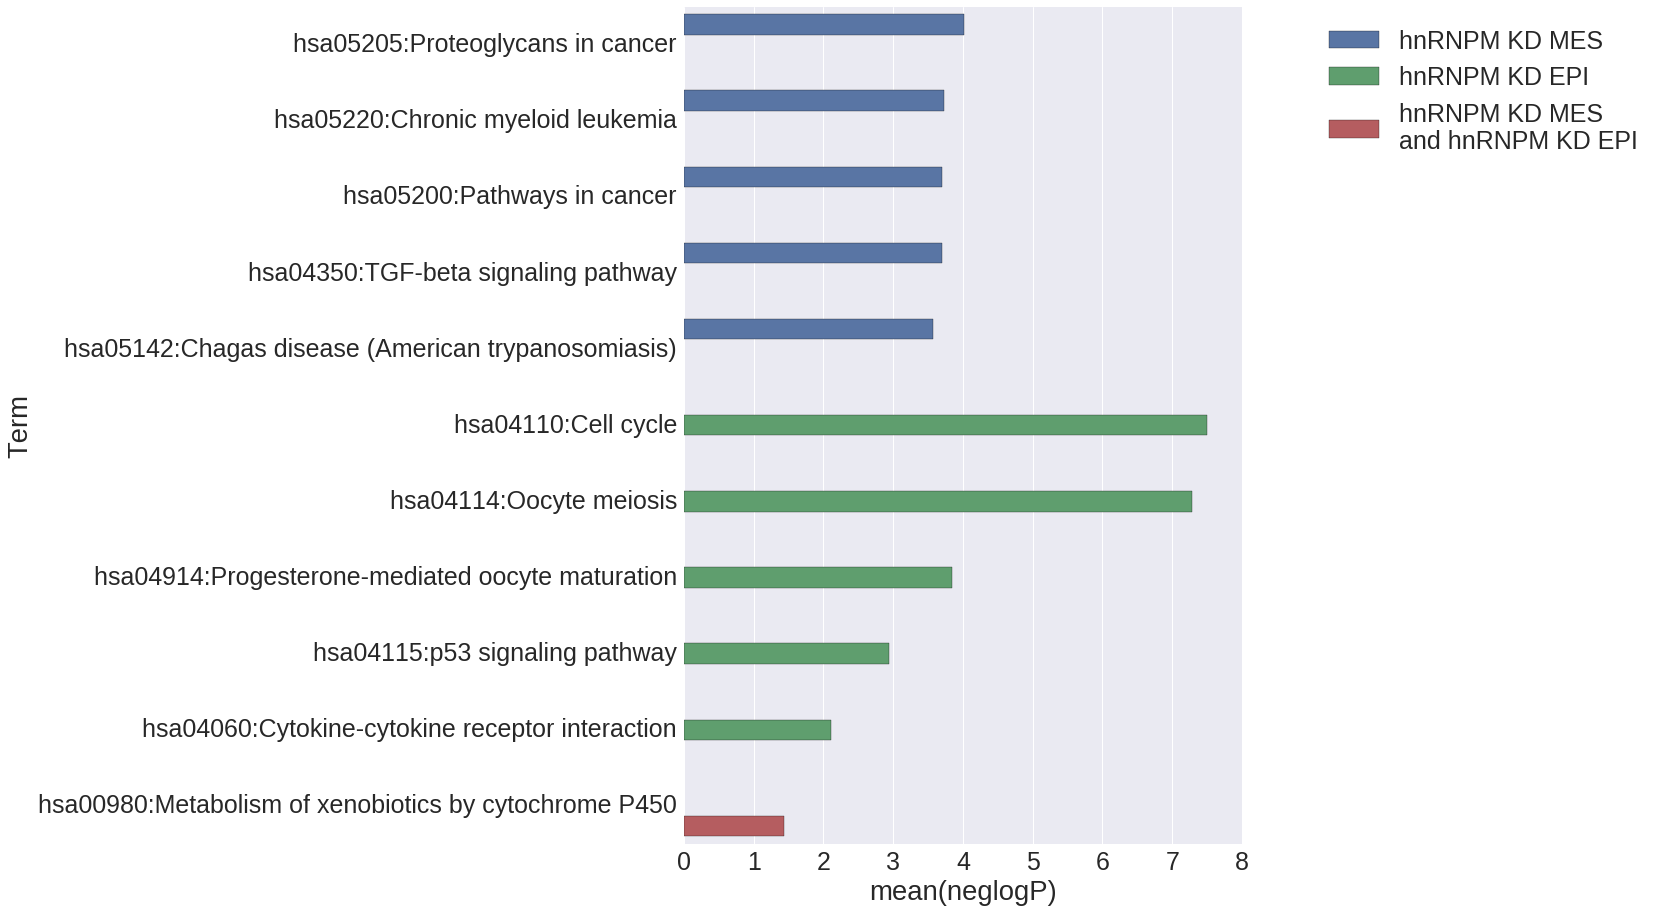

In [27]:
#EPI VS MES GENE EXPRESSION - KEGG

cc1_cc4_gene = 'master_go_analysis/epi_vs_mes_hnM_knockdown_genes_diff_log_ratio_1/cc1_cc4_gene_diff_only.txt'
hh5_hh6_gene = 'master_go_analysis/epi_vs_mes_hnM_knockdown_genes_diff_log_ratio_1/hh5_hh6_gene_diff_only.txt'
both_gene = 'master_go_analysis/epi_vs_mes_hnM_knockdown_genes_diff_log_ratio_1/cc1_cc4_hh5_hh6_intersection_gene.txt'
# compare_gene_and_gene(cc1_cc4_cuff_df_filtered,hh5_hh6_cuff_df_filtered,'hnRNPM KD MES','hnRNPM KD EPI')
david_bar_graph(cc1_cc4_gene,hh5_hh6_gene,both_gene,'hnRNPM KD MES','hnRNPM KD EPI','KEGG_PATHWAY',1.3)

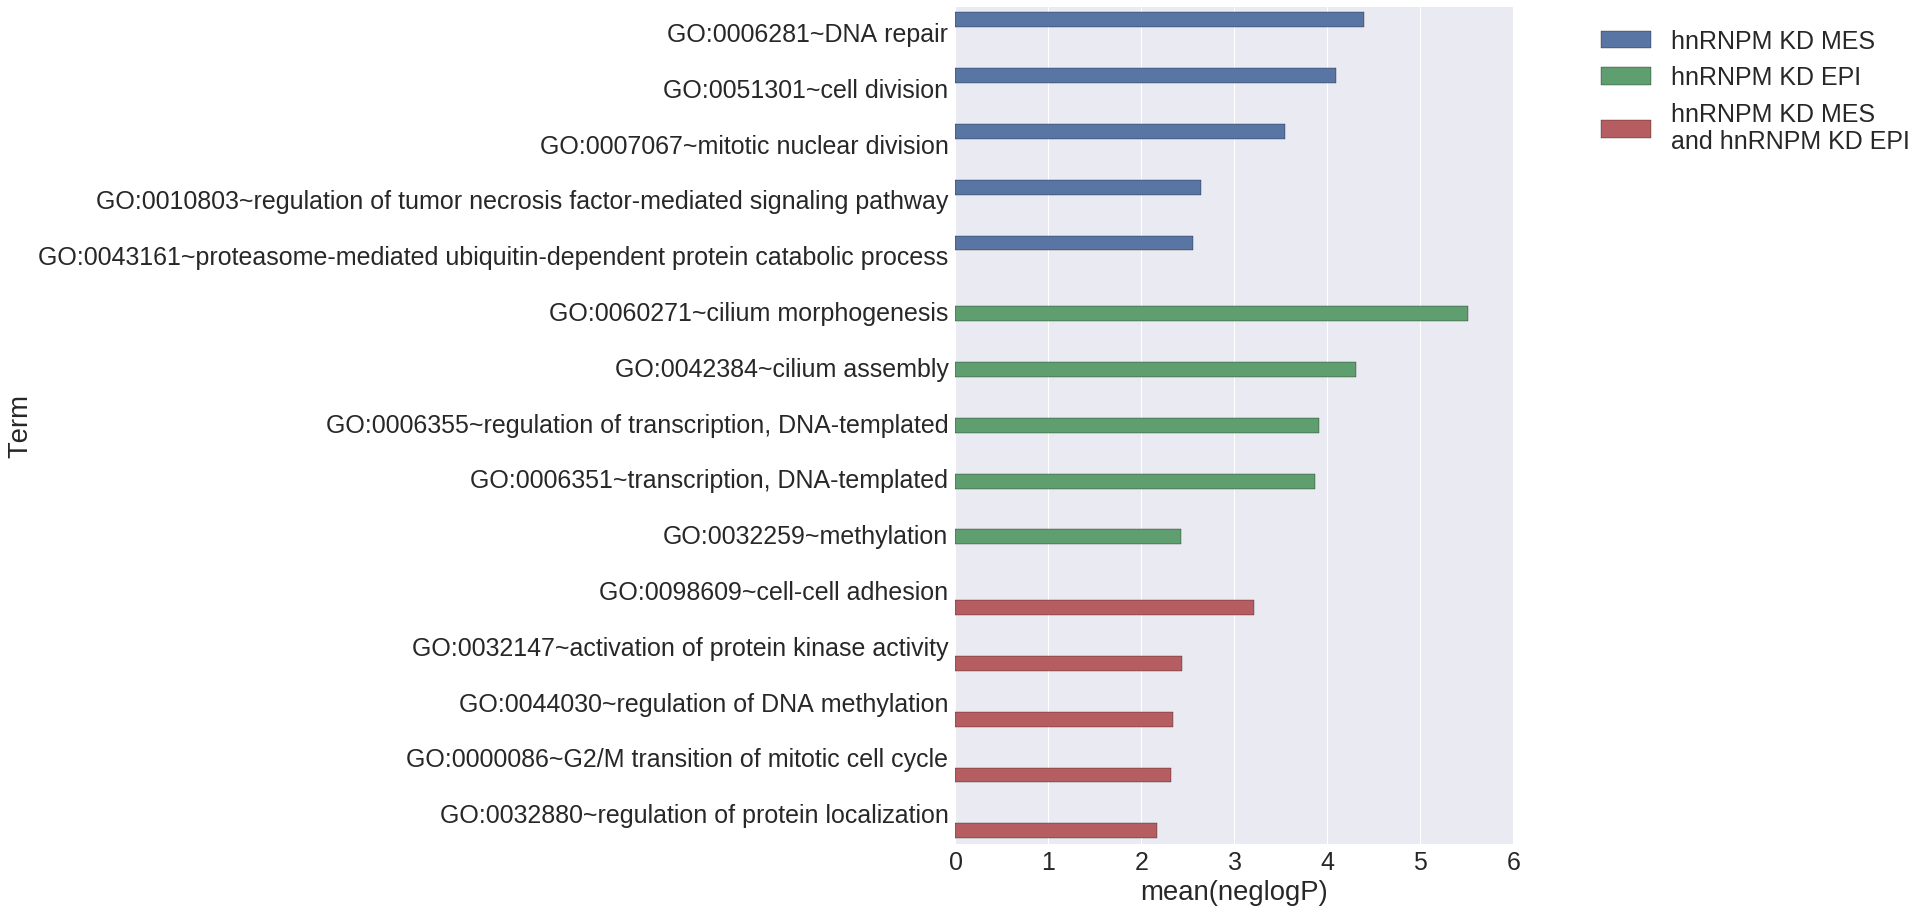

In [28]:
#EPI VS MES SPLICING - not necessarily bound
#Here we are comparing significant splice events regardless of binding and are the same or different in epithelial vs. mesenchymal state
cc1_cc4_splice = 'master_go_analysis/epi_vs_mes_hnM_knockdown_splice_diff_fdr_0.05_dPSI_0.1/cc1_cc4_splice_only.txt'
hh5_hh6_splice = 'master_go_analysis/epi_vs_mes_hnM_knockdown_splice_diff_fdr_0.05_dPSI_0.1/hh5_hh6_splice_only.txt'
both_splice = 'master_go_analysis/epi_vs_mes_hnM_knockdown_splice_diff_fdr_0.05_dPSI_0.1/cc1_cc4_hh5_hh6_intersection_splice.txt'
# compare_spliced_and_spliced(cc1_cc4_rMATS_df_filtered,hh5_hh6_rMATS_df_filtered,'hnRNPM KD MES','hnRNPM KD EPI')
david_bar_graph(cc1_cc4_splice,hh5_hh6_splice,both_splice,'hnRNPM KD MES','hnRNPM KD EPI','GOTERM_BP_DIRECT',1.5)

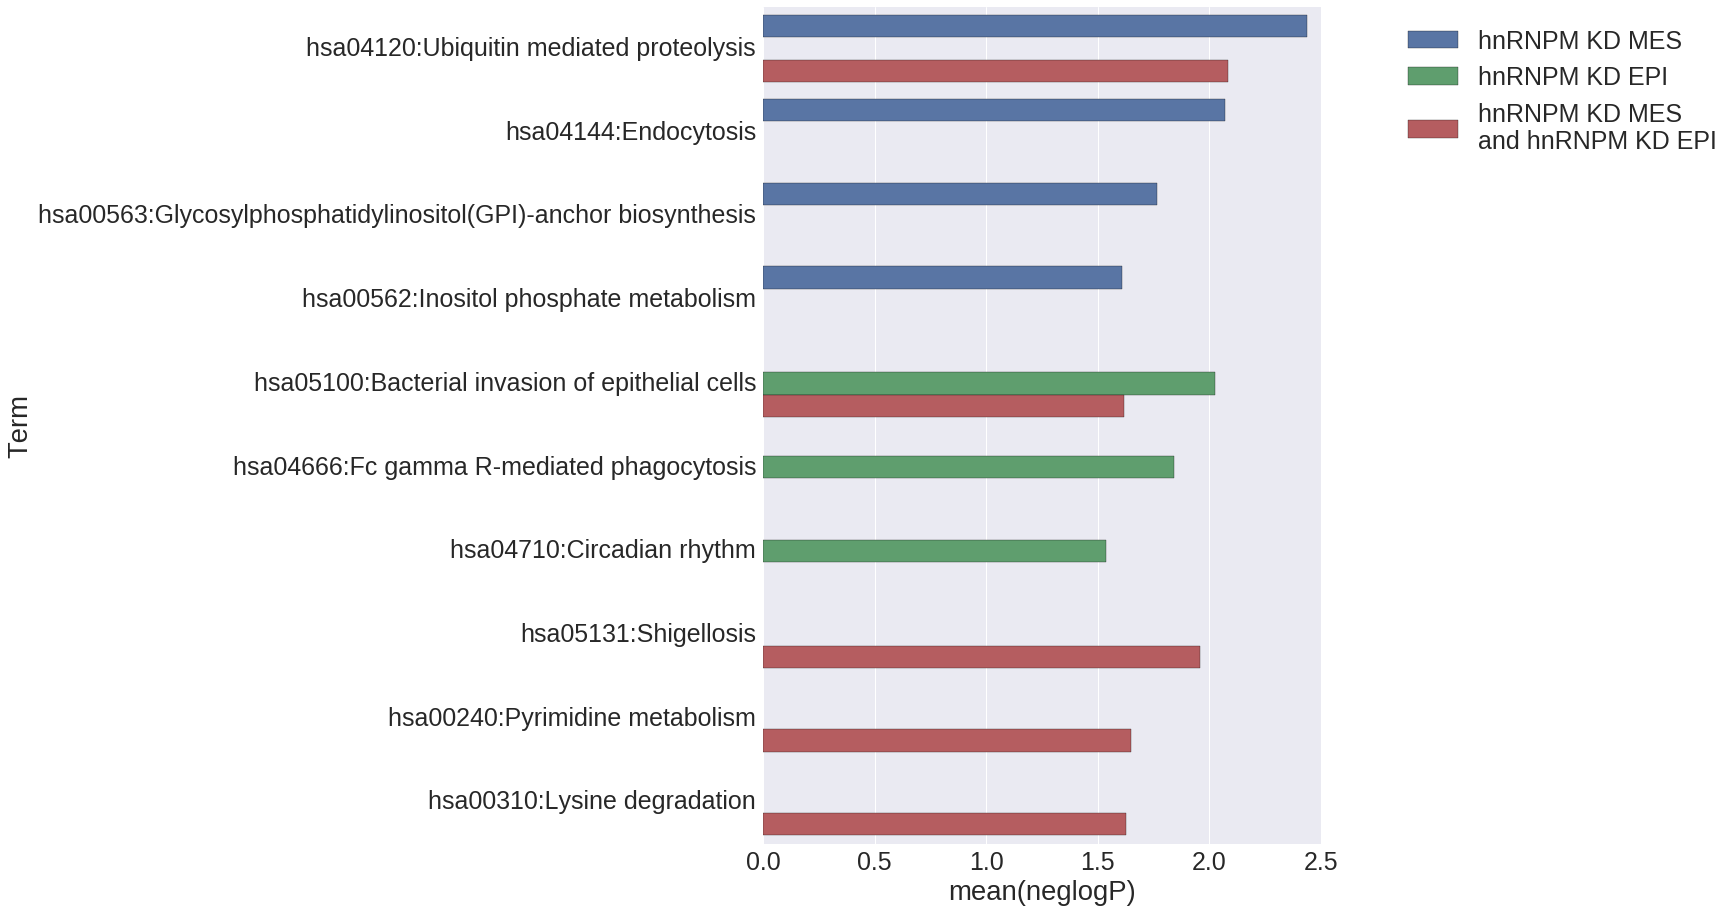

In [65]:
#EPI VS MES SPLICING - not necessarily bound
cc1_cc4_splice = 'master_go_analysis/epi_vs_mes_hnM_knockdown_splice_diff_fdr_0.05_dPSI_0.1/cc1_cc4_splice_only.txt'
hh5_hh6_splice = 'master_go_analysis/epi_vs_mes_hnM_knockdown_splice_diff_fdr_0.05_dPSI_0.1/hh5_hh6_splice_only.txt'
both_splice = 'master_go_analysis/epi_vs_mes_hnM_knockdown_splice_diff_fdr_0.05_dPSI_0.1/cc1_cc4_hh5_hh6_intersection_splice.txt'
# compare_spliced_and_spliced(cc1_cc4_rMATS_df_filtered,hh5_hh6_rMATS_df_filtered,'hnRNPM KD MES','hnRNPM KD EPI')
david_bar_graph(cc1_cc4_splice,hh5_hh6_splice,both_splice,'hnRNPM KD MES','hnRNPM KD EPI','KEGG_PATHWAY',1.5)

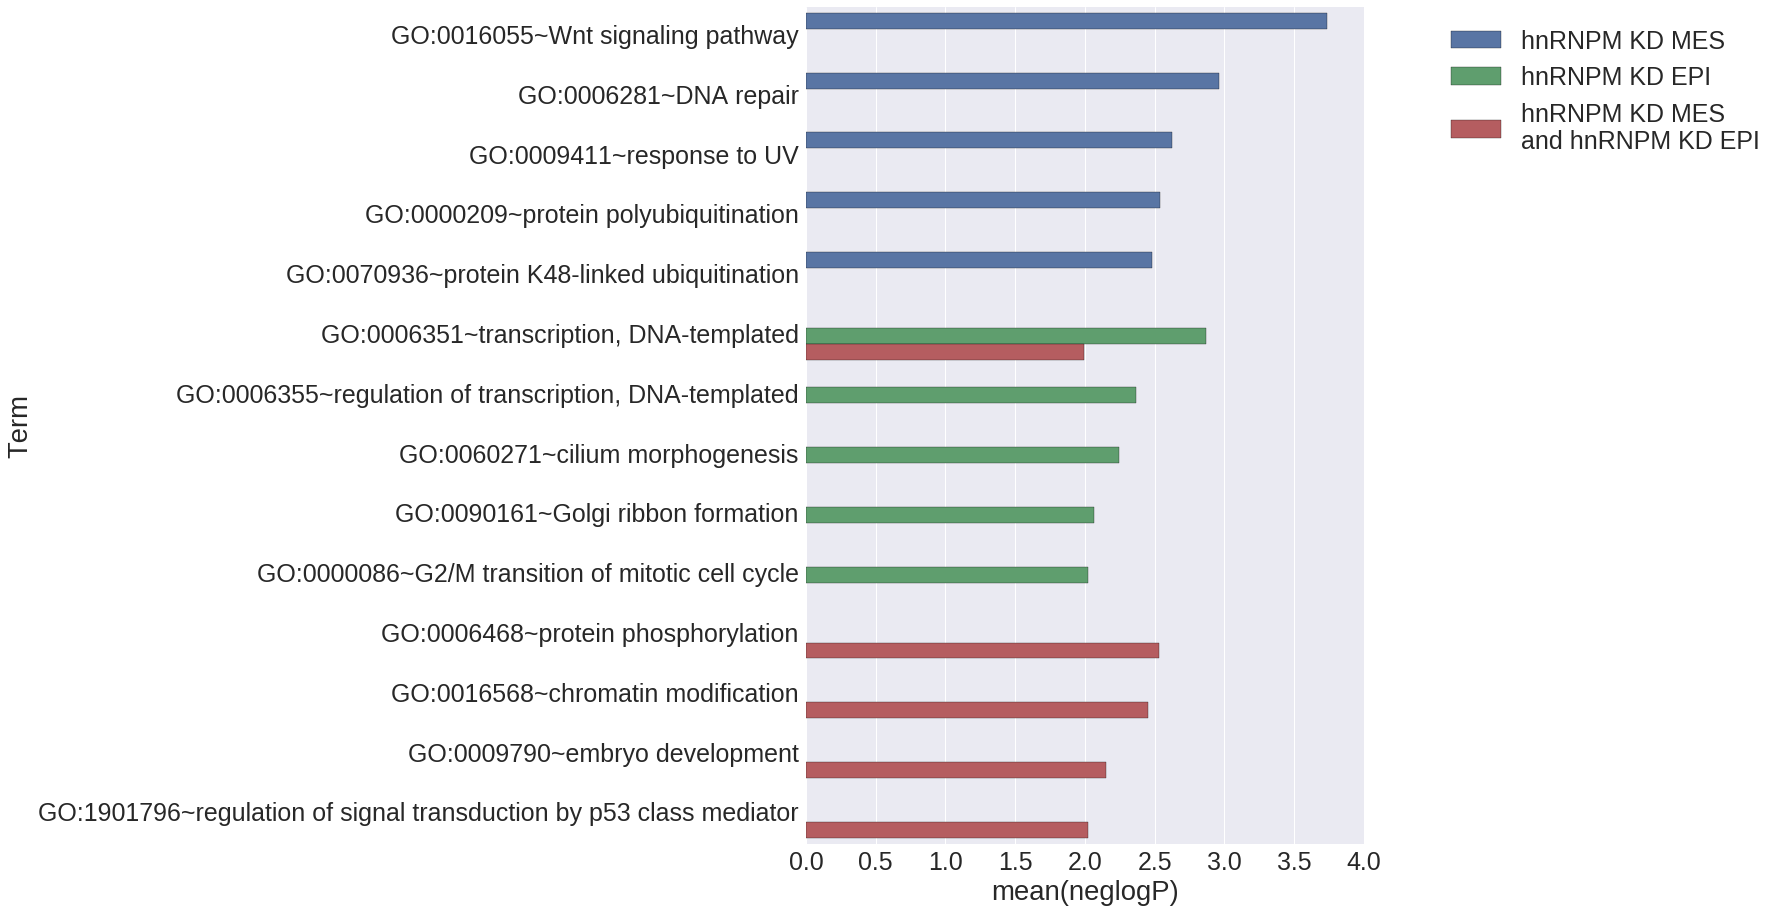

In [66]:
#EPI VS MES SPLICING BOUND - THIS IS BOUND, NOT JUST DIFF SPLICED
#Here we are comparing significant splice events that are bound and are the same or different in epithelial vs. mesenchymal state
cc1_cc4_splice = 'master_go_analysis/epi_vs_mes_hnM_KD_v_intersect_splice_diff_fdr_0.05_dPSI_0.1/cc1_cc4_v_intersect_spliced_only.txt'
hh5_hh6_splice = 'master_go_analysis/epi_vs_mes_hnM_KD_v_intersect_splice_diff_fdr_0.05_dPSI_0.1/hh5_hh6_v_intersect_spliced_only.txt'
both_splice = 'master_go_analysis/epi_vs_mes_hnM_KD_v_intersect_splice_diff_fdr_0.05_dPSI_0.1/cc1_cc4_hh5_hh6_v_intersect_spliced.txt'
david_bar_graph(cc1_cc4_splice,hh5_hh6_splice,both_splice,'hnRNPM KD MES','hnRNPM KD EPI','GOTERM_BP_DIRECT',1.5)

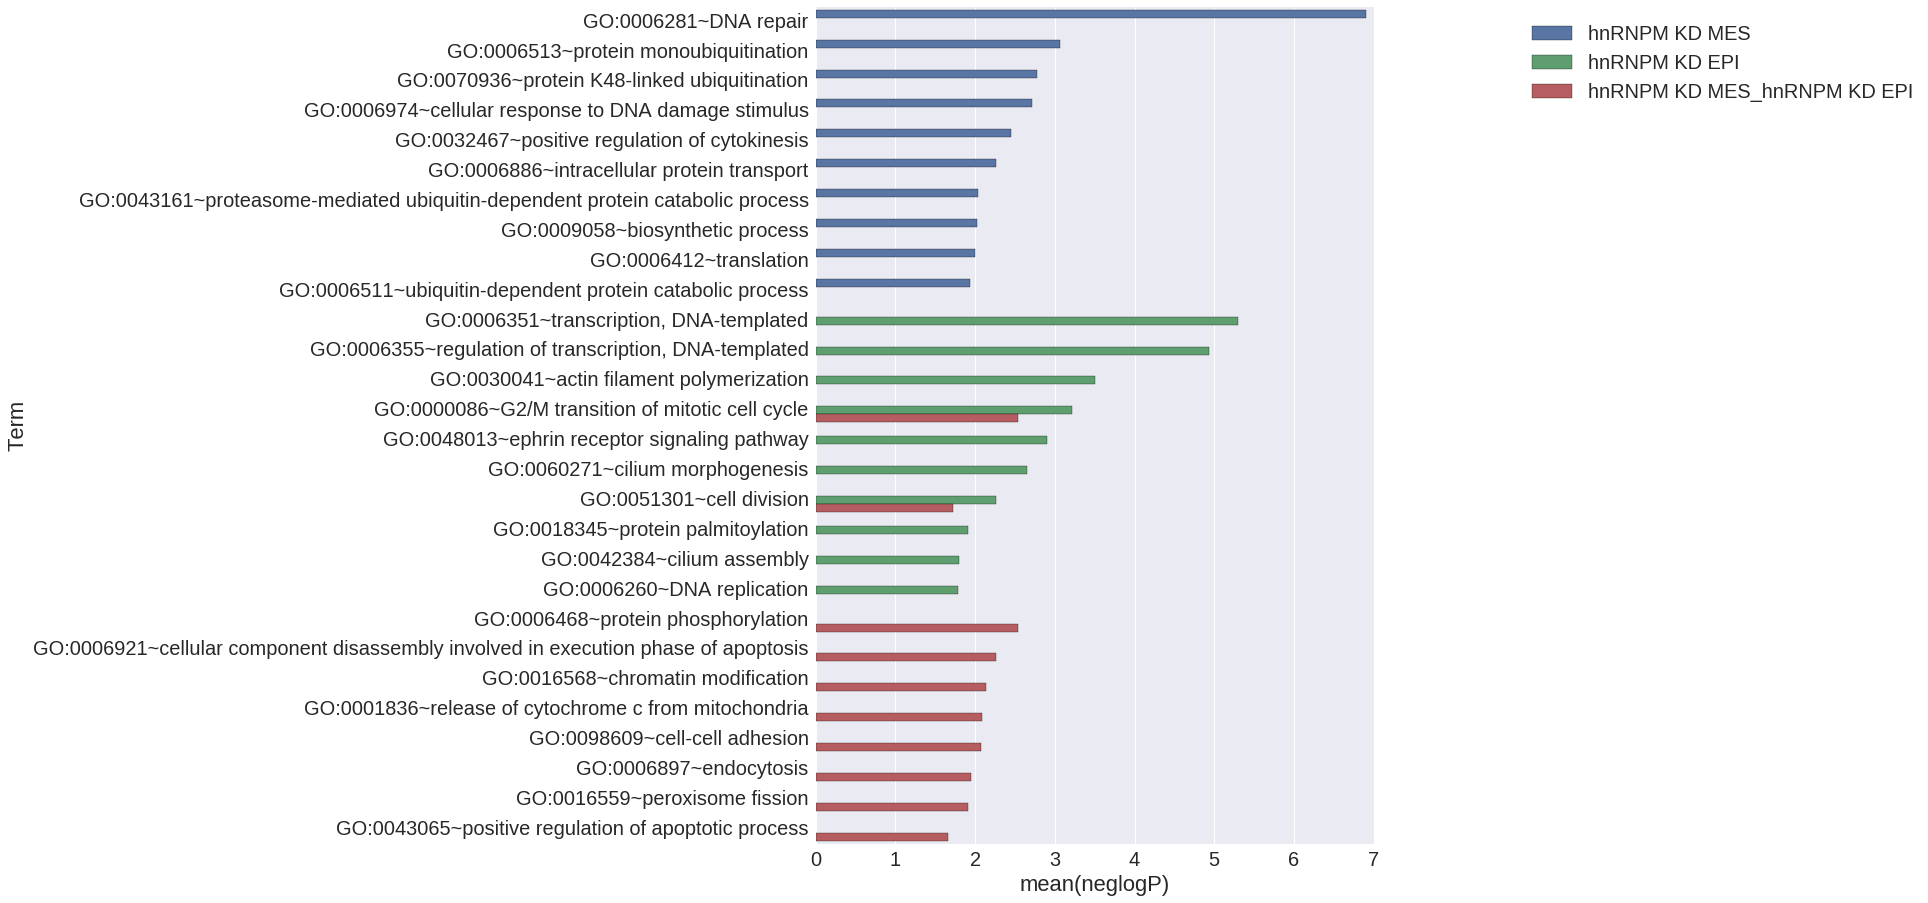

In [35]:
#Twist whole intersect - cool
#EPI VS MES SPLICING BOUND - THIS IS BOUND, NOT JUST DIFF SPLICED
#Here we are comparing significant splice events that are bound and are the same or different in epithelial vs. mesenchymal state
cc1_cc4_splice = 'master_go_analysis/epi_vs_mes_hnM_KD_whole_intersect_splice_diff_fdr_0.05_dPSI_0.1/david_mes_only.txt'
hh5_hh6_splice = 'master_go_analysis/epi_vs_mes_hnM_KD_whole_intersect_splice_diff_fdr_0.05_dPSI_0.1/david_epi_only.txt'
both_splice = 'master_go_analysis/epi_vs_mes_hnM_KD_whole_intersect_splice_diff_fdr_0.05_dPSI_0.1/david_intersection.txt'
# compare_spliced_and_spliced(cc1_cc4_rMATS_df_filtered,hh5_hh6_rMATS_df_filtered,'hnRNPM KD MES','hnRNPM KD EPI')
david_bar_graph(cc1_cc4_splice,hh5_hh6_splice,both_splice,'hnRNPM KD MES','hnRNPM KD EPI','GOTERM_BP_DIRECT',1.3)

In [36]:
#Other GO lists to do
#differentially bound genes
#differentially bound splicing events
#for each of these compare epi and compare mes

#Then get into the weeds... bound vs. unbound in each condition as well as those associated with gene expression or splicing in a particular direction during EMT

In [61]:
#Note - I do not require that the actual genes be identical sets

def collect_and_process_intersection_ids(binding_set,spliced_set,output_prefix):
    #compute intersections
    intersection = binding_set.intersection(spliced_set)
    binding_only = binding_set.difference(spliced_set)
    spliced_only = spliced_set.difference(binding_set)
    #process splice ID to list of ens_genes
    intersection_list = list(intersection)
    intersection_ens_gene_set = set()
    for item in intersection_list:
        item = item.strip().split(':')
        ens_gene = item[6]
        intersection_ens_gene_set.add(ens_gene)
    
    binding_only_list = list(binding_only)
    binding_only_ens_gene_set = set()
    for item in binding_only_list:
        item = item.strip().split(':')
        ens_gene = item[6]
        binding_only_ens_gene_set.add(ens_gene)
    
    spliced_only_list = list(spliced_only)
    spliced_only_ens_gene_set = set()
    for item in spliced_only_list:
        item = item.strip().split(':')
        ens_gene = item[6]
        spliced_only_ens_gene_set.add(ens_gene)
    
    intersection_out = list(intersection_ens_gene_set)
    with open(output_prefix+'/intersection_ens_gene','w') as f:
        for line in intersection_out:
            f.write(line+'\n')            
    binding_only_out = list(binding_only_ens_gene_set)
    with open(output_prefix+'/left_set_only_ens_gene','w') as f:
        for line in binding_only_out:
            f.write(line+'\n')            
    spliced_only_out = list(spliced_only_ens_gene_set)
    with open(output_prefix+'/right_set_only_ens_gene','w') as f:
        for line in spliced_only_out:
            f.write(line+'\n')
            
    #also do a venn3 on these ens_gene_sets
    plt.figure(figsize=(8,8))
    plt.title('Venn between intersection genes, left_set genes, and right_set genes',fontsize=20)
    mplv.venn3([intersection_ens_gene_set,binding_only_ens_gene_set,spliced_only_ens_gene_set],set_labels=('intersection_ens_gene','left_set_only_ens_gene','right_set_only_ens_gene'))

    return 'Done'

<matplotlib_venn._common.VennDiagram instance at 0x7f965b391200>

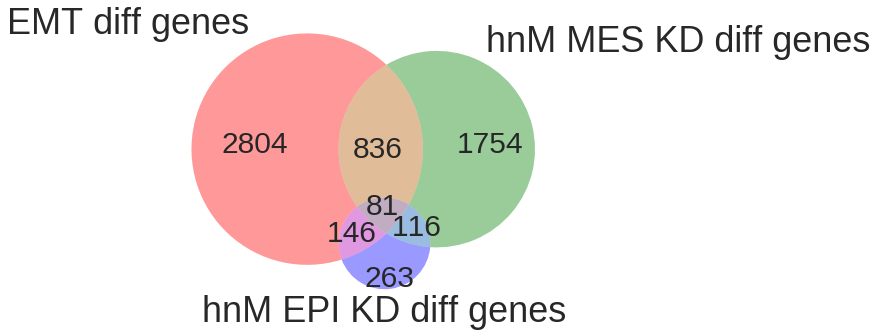

In [62]:
#Do the comparison between EMT, hh5, and cc1 genes
twist_set = set(twist_cuff_df_filtered.ens_gene.tolist())
cc1_cc4_set = set(cc1_cc4_cuff_df_filtered.ens_gene.tolist())
hh5_hh6_set = set(hh5_hh6_cuff_df_filtered.ens_gene.tolist())

mplv.venn3([twist_set,cc1_cc4_set,hh5_hh6_set],set_labels=['EMT diff genes','hnM MES KD diff genes','hnM EPI KD diff genes'])

<matplotlib_venn._common.VennDiagram instance at 0x7f966162a758>

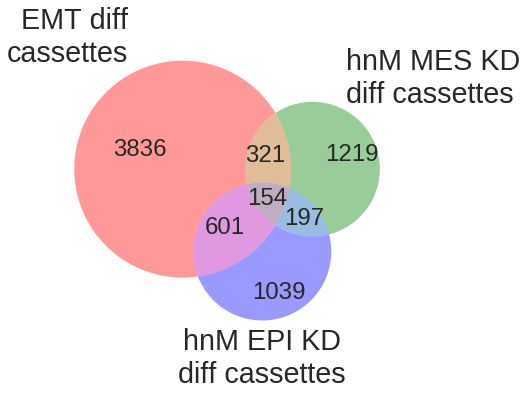

In [63]:
#Do the comparison between EMT, hh5, and cc1 spliced_genes
sns.set(font_scale=2)
twist_set = set(twist_rMATS_df_filtered.splice_id.tolist())
cc1_cc4_set = set(cc1_cc4_rMATS_df_filtered.splice_id.tolist())
hh5_hh6_set = set(hh5_hh6_rMATS_df_filtered.splice_id.tolist())

mplv.venn3([twist_set,cc1_cc4_set,hh5_hh6_set],set_labels=['EMT diff\ncassettes','hnM MES KD\ndiff cassettes','hnM EPI KD\ndiff cassettes'])

In [ ]:
#how about bound
twist_bound_set = set()

In [40]:
#plot pie charts of how many things are skipped or included? in each of the datasets



In [41]:
len(twist_rMATS_df_filtered)

4912

In [42]:
#save the twist diff gene list, included and skipped
twist_genes = twist_rMATS_df_filtered.ens_gene
twist_genes.to_csv('master_go_analysis/twist_differentially_spliced_genes.txt',header=True,index=False)

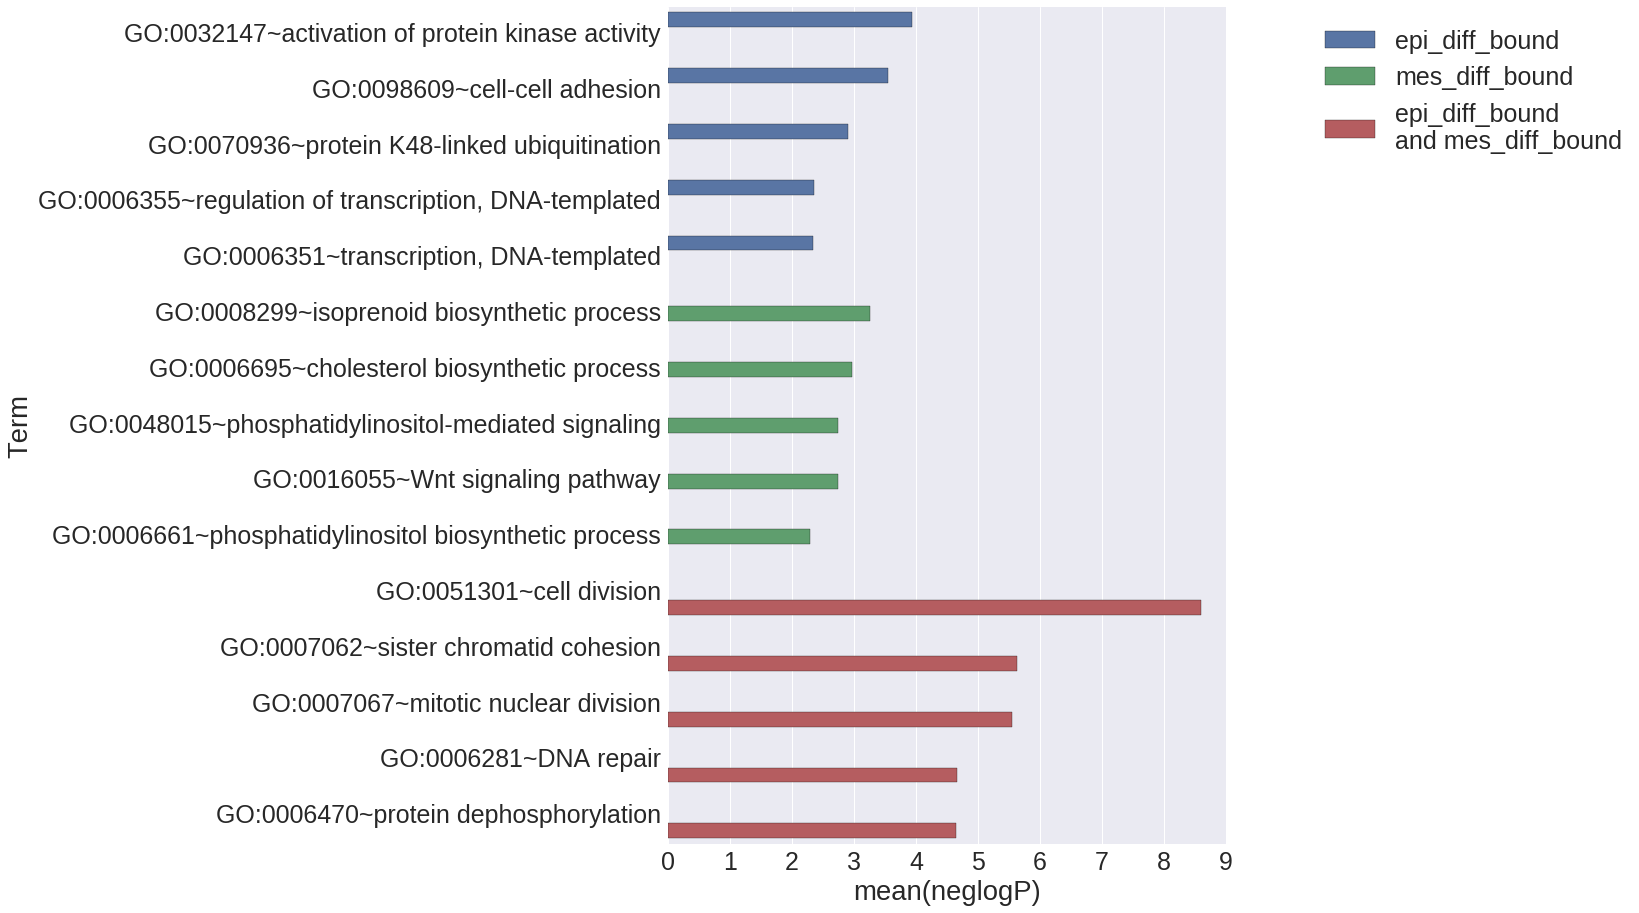

In [64]:
#now do GO on the EMT differential splicing sets...
#What is this obtained from?
#This is key - it shows that for things that are differentially bound during EMT we have binding this is associated with positive or negative psi value
#do the different bound, unbound, etc.
twist_epi_diff_bound_all = 'master_go_analysis/twist_diff_bound_epi/david_epi_all_bound.txt'
twist_mes_diff_bound_all = 'master_go_analysis/twist_diff_bound_mes/david_mes_all_bound.txt'
twist_true_unbound_but_diff_spliced = 'master_go_analysis/twist_diff_true_unbound/david_twist_true_unbound.txt'
david_bar_graph(twist_epi_diff_bound_all,twist_mes_diff_bound_all,twist_true_unbound_but_diff_spliced,'epi_diff_bound','mes_diff_bound','GOTERM_BP_DIRECT',2)

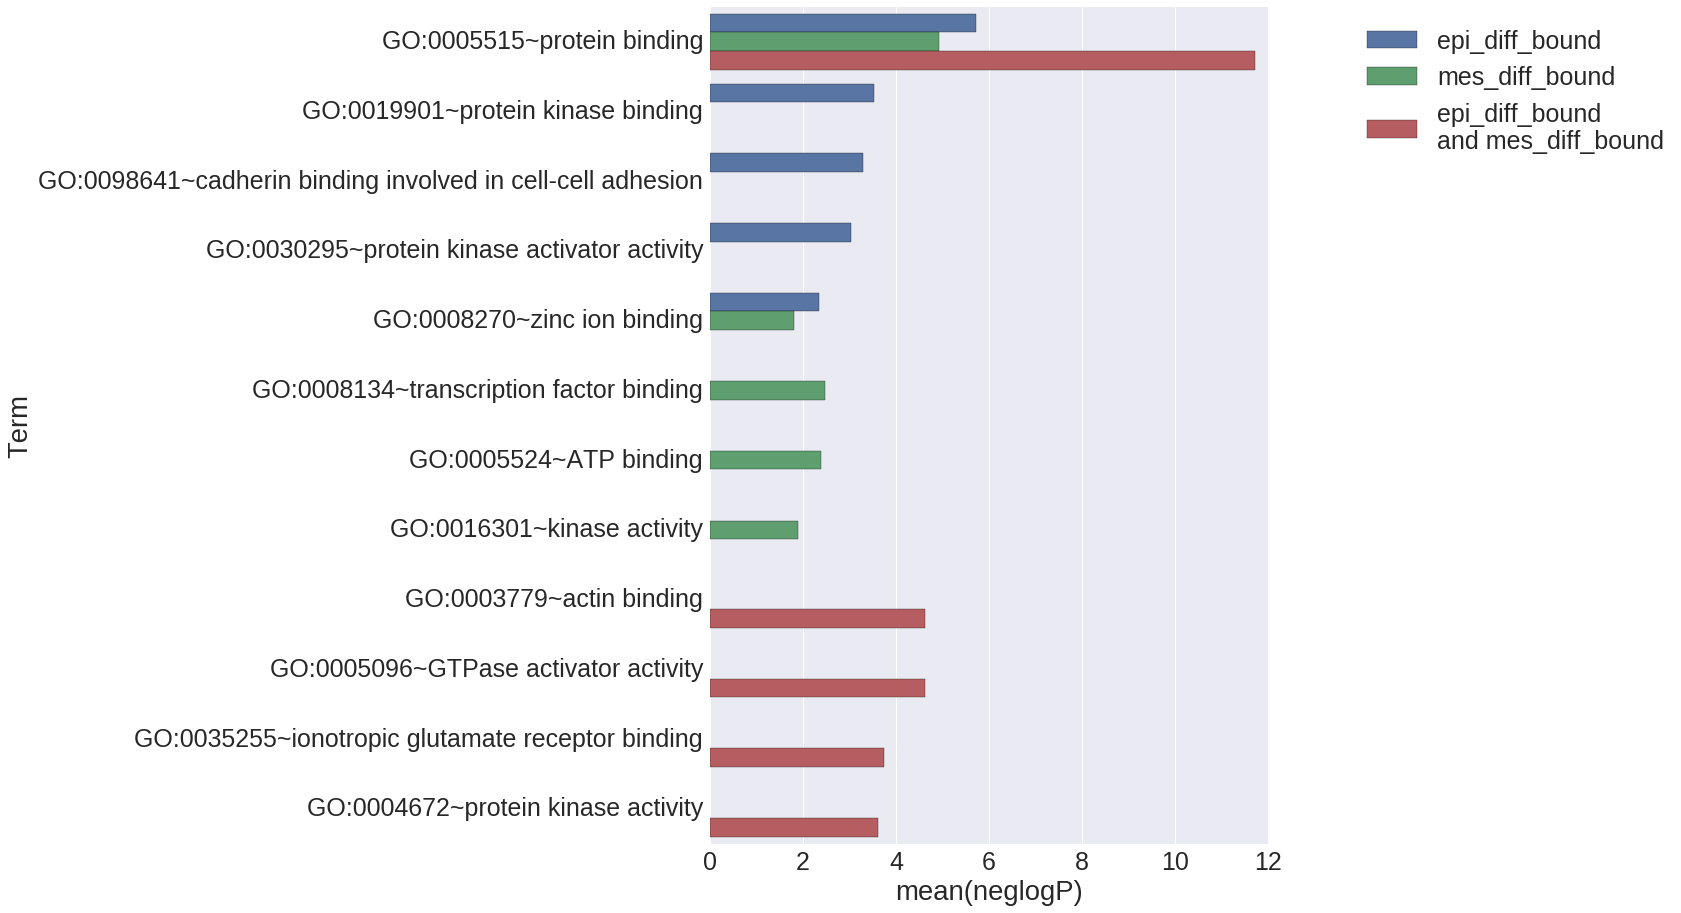

In [194]:
#now do GO on the EMT differential splicing sets...
#do the different bound, unbound, etc.
twist_epi_diff_bound_all = 'master_go_analysis/twist_diff_bound_epi/david_epi_all_bound.txt'
twist_mes_diff_bound_all = 'master_go_analysis/twist_diff_bound_mes/david_mes_all_bound.txt'
twist_true_unbound_but_diff_spliced = 'master_go_analysis/twist_diff_true_unbound/david_twist_true_unbound.txt'
david_bar_graph(twist_epi_diff_bound_all,twist_mes_diff_bound_all,twist_true_unbound_but_diff_spliced,'epi_diff_bound','mes_diff_bound','GOTERM_MF_DIRECT',1.3)

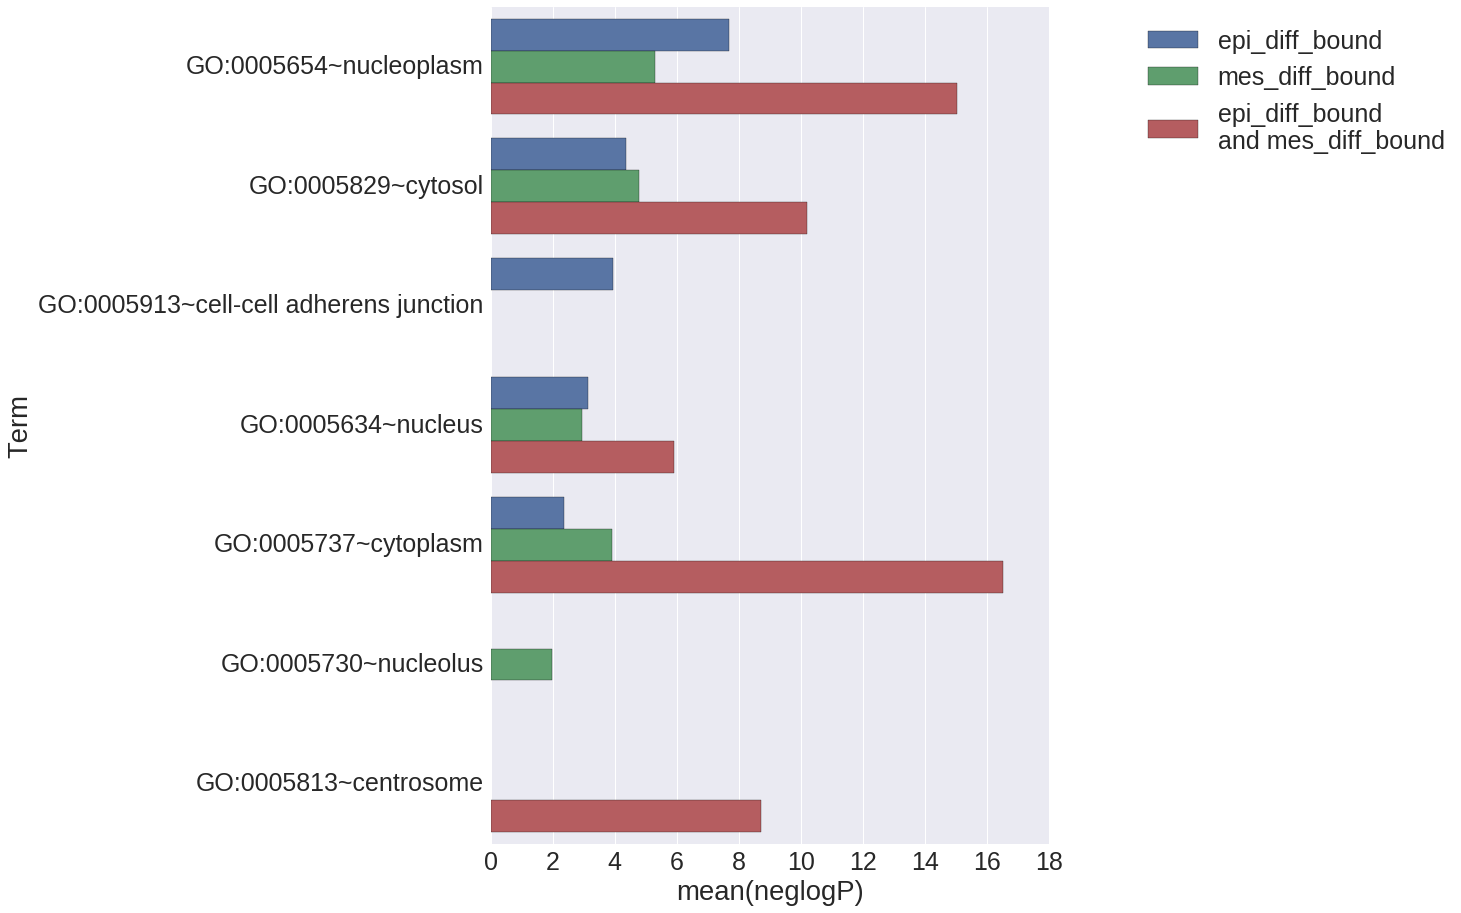

In [197]:
#now do GO on the EMT differential splicing sets...
#do the different bound, unbound, etc.
twist_epi_diff_bound_all = 'master_go_analysis/twist_diff_bound_epi/david_epi_all_bound.txt'
twist_mes_diff_bound_all = 'master_go_analysis/twist_diff_bound_mes/david_mes_all_bound.txt'
twist_true_unbound_but_diff_spliced = 'master_go_analysis/twist_diff_true_unbound/david_twist_true_unbound.txt'
david_bar_graph(twist_epi_diff_bound_all,twist_mes_diff_bound_all,twist_true_unbound_but_diff_spliced,'epi_diff_bound','mes_diff_bound','GOTERM_CC_DIRECT',1.3)

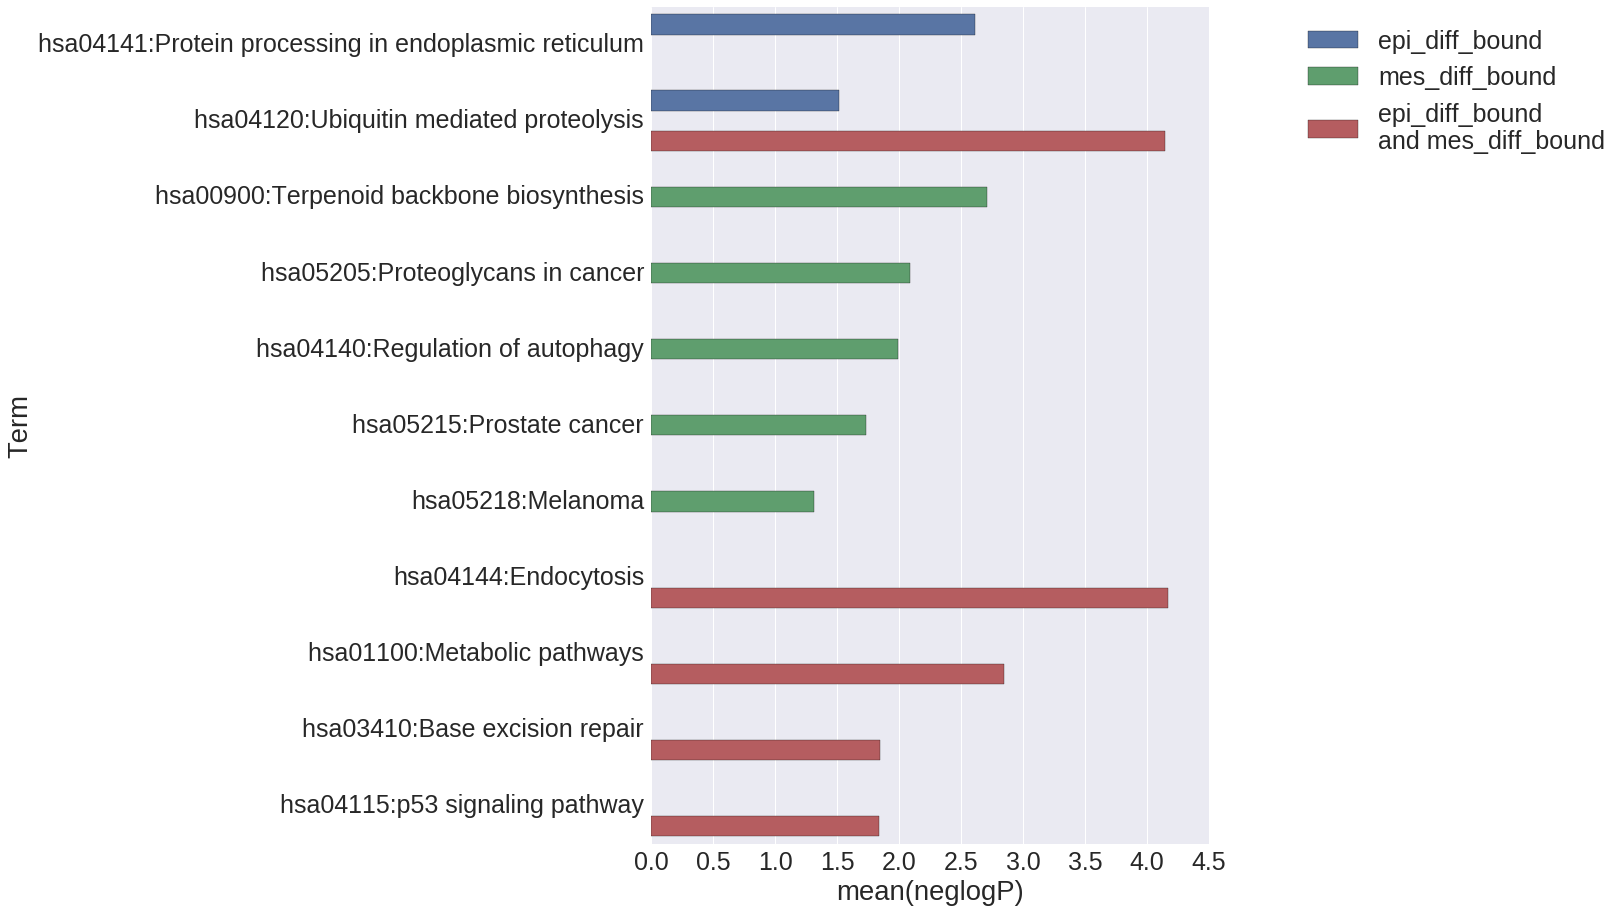

In [198]:
#now do GO on the EMT differential splicing sets...
#do the different bound, unbound, etc.
twist_epi_diff_bound_all = 'master_go_analysis/twist_diff_bound_epi/david_epi_all_bound.txt'
twist_mes_diff_bound_all = 'master_go_analysis/twist_diff_bound_mes/david_mes_all_bound.txt'
twist_true_unbound_but_diff_spliced = 'master_go_analysis/twist_diff_true_unbound/david_twist_true_unbound.txt'
david_bar_graph(twist_epi_diff_bound_all,twist_mes_diff_bound_all,twist_true_unbound_but_diff_spliced,'epi_diff_bound','mes_diff_bound','KEGG_PATHWAY',1.3)

In [172]:
#How many of the expressed genes are lncRNAs in each state
d0_df = twist_cuff_df[twist_cuff_df.value_1 > 5]
d14_df = twist_cuff_df[twist_cuff_df.value_2 > 5]

In [173]:
d0_df.head()

,ens_gene,external_gene_name,locus,value_1,value_2,log2_fold_change,q_value,biotype
0,ENSG00000000003,TSPAN6,chrX:99883666-99894988,7.80703,7.20490,-0.115795,0.991127,protein_coding
2,ENSG00000000419,DPM1,chr20:49505452-49575092,21.24340,12.94020,-0.715151,0.990666,protein_coding
7,ENSG00000001036,FUCA2,chr6:143771943-143832827,19.44940,26.13810,0.426429,0.990666,protein_coding
8,ENSG00000001084,GCLC,chr6:53362138-53481969,74.28710,5.06533,-3.874380,0.085147,protein_coding
9,ENSG00000001167,NFYA,chr6:40994771-41067715,11.66660,6.12209,-0.930292,0.990666,protein_coding


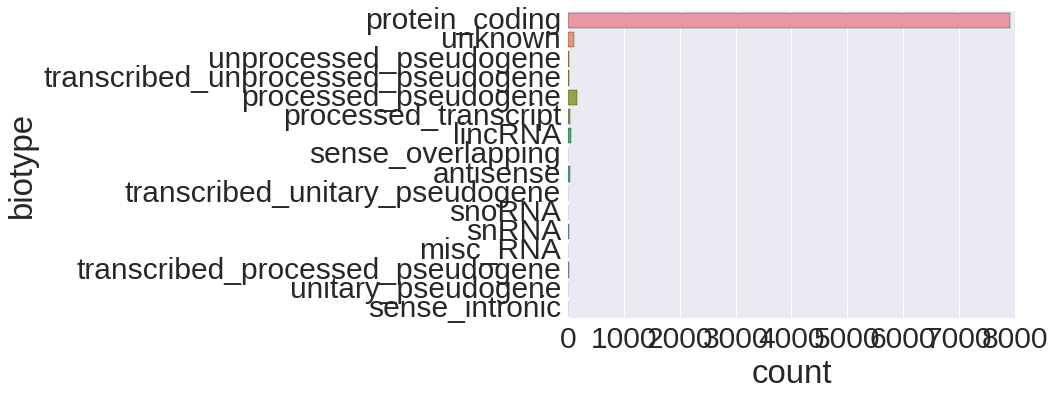

In [174]:
sns.countplot(y='biotype',data=d0_df,orient='h')

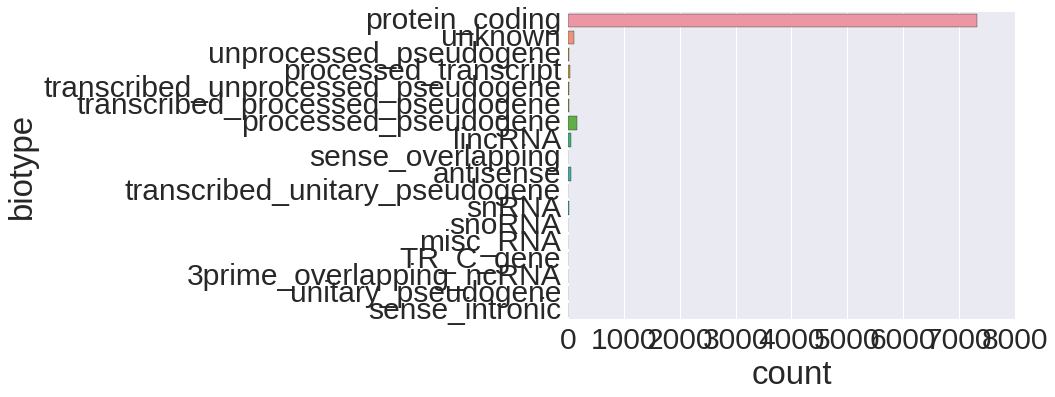

In [175]:
sns.countplot(y='biotype',data=d14_df,orient='h')

In [77]:
twist_cuff_df.head()

,ens_gene,external_gene_name,locus,value_1,value_2,log2_fold_change,q_value,biotype
0,ENSG00000000003,TSPAN6,chrX:99883666-99894988,7.80703,7.20490,-0.115795,0.991127,protein_coding
1,ENSG00000000005,TNMD,chrX:99839798-99854882,0.00000,0.00000,0.000000,1.000000,protein_coding
2,ENSG00000000419,DPM1,chr20:49505452-49575092,21.24340,12.94020,-0.715151,0.990666,protein_coding
3,ENSG00000000457,SCYL3,chr1:169631244-169863408,1.26274,1.07149,-0.236950,0.991127,protein_coding
4,ENSG00000000460,C1orf112,chr1:169631244-169863408,2.70073,3.00648,0.154727,0.990916,protein_coding


In [95]:
#are lncrnas diff expressed?
twist_cuff_df_filt = twist_cuff_df[(twist_cuff_df.value_1 > 1) | (twist_cuff_df.value_2 > 1)]
twist_cuff_df_filt = twist_cuff_df_filt[twist_cuff_df_filt.biotype == 'lincRNA']
fold = 1
twist_cuff_df_filt = twist_cuff_df_filt[twist_cuff_df_filt.log2_fold_change.abs() > fold]
twist_cuff_df_filt_mes = twist_cuff_df_filt[twist_cuff_df_filt.log2_fold_change > fold]
twist_cuff_df_filt_epi = twist_cuff_df_filt[twist_cuff_df_filt.log2_fold_change < -fold]



In [94]:
twist_cuff_df_filt_mes.describe()

,value_1,value_2,log2_fold_change,q_value
count,66.000000,66.000000,66.000000,66.000000
mean,1.396938,6.148674,inf,0.872759
std,2.389057,9.830000,NaN,0.187663
min,0.000000,1.009070,1.045770,0.043038
25%,0.258565,1.360592,1.456395,0.822224
50%,0.513990,2.748410,2.064205,0.959548
75%,1.328105,5.294467,2.826325,0.990666
max,13.418200,51.863300,inf,0.990666


In [99]:
twist_cuff_df_filt_epi.describe()

,value_1,value_2,log2_fold_change,q_value
count,50.000000,50.000000,50.000000,50.000000
mean,9.301966,2.174486,-2.669025,0.875079
std,25.511525,7.249985,1.548923,0.181069
min,1.010630,0.016282,-6.832510,0.203778
25%,1.588485,0.271142,-3.610060,0.820756
50%,2.712850,0.511712,-2.122885,0.990666
75%,7.487772,1.311527,-1.322530,0.990666
max,177.998000,51.341700,-1.003380,0.990666


(-10.0, 200)

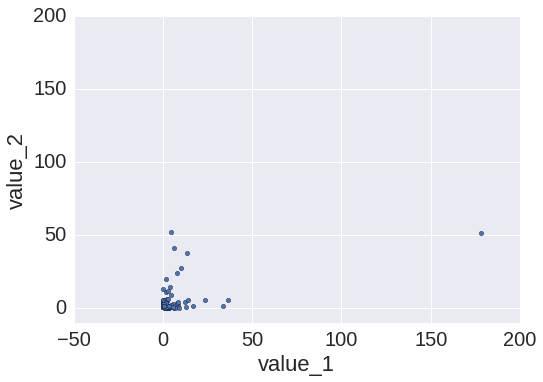

In [111]:
twist_cuff_df_filt.plot.scatter(x='value_1',y='value_2')
plt.xlim(right=200)
plt.ylim(top=200)

In [106]:
twist_cuff_df_filt.sort_values(by='value_2',ascending=False)

,ens_gene,external_gene_name,locus,value_1,value_2,log2_fold_change,q_value,biotype
32427,ENSG00000231826,AC016735.2,chr2:43254991-43266686,4.503870,51.863300,3.525480,0.717822,lincRNA
55942,ENSG00000269893,SNHG8,chr4:119199863-119200978,177.998000,51.341700,-1.793660,0.841681,lincRNA
11098,ENSG00000163364,AC017048.3,chr2:177494316-177520686,6.077960,41.464100,2.770210,0.720161,lincRNA
23773,ENSG00000214548,MEG3,chr14:101245746-101327368,13.418200,37.922100,1.498840,0.818579,lincRNA
42543,ENSG00000250786,CTD-2001E22.2,chr5:9546311-9550721,10.226100,27.162700,1.409370,0.973744,lincRNA
40554,ENSG00000245937,CTC-228N24.3,chr5:127039081-127418792,8.092850,23.941000,1.564760,0.910440,lincRNA
26591,ENSG00000223749,AC004383.4,chrX:133677366-133680741,1.766510,19.721000,3.480760,0.746552,lincRNA
16568,ENSG00000186594,MIR22HG,chr17:1614804-1641893,4.086880,14.444100,1.821410,0.959899,lincRNA
28058,ENSG00000225783,MIAT,chr22:27042391-27176170,0.075560,12.786300,7.402770,0.294277,lincRNA
47791,ENSG00000257698,RP11-620J15.3,chr12:58325310-58329958,2.994370,11.902800,1.990970,0.988113,lincRNA


In [ ]:
#try this with the new cufflinks


In [199]:
len(twist_rMATS_df_filtered[twist_rMATS_df_filtered.IncLevelDifference > 0])

1871

In [200]:
print(len(twist_rMATS_df_filtered[twist_rMATS_df_filtered.IncLevelDifference < 0])

3041